<a href="https://colab.research.google.com/github/kzumreen/FoodTrendsPrediction/blob/main/Reddit_Access.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Reddit API EDA
This notebook pulls data from Reddit API via PRAW and its respective exploratory data analysis.

In [1]:
!pip install praw pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 3.9 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
import praw
import time
import pandas as pd

In [3]:
CLIENT_ID = userdata.get("REDDIT_CLIENT_ID")
CLIENT_SECRET = userdata.get("REDDIT_CLIENT_SECRET")
USER_AGENT = userdata.get("REDDIT_USER_AGENT")

In [4]:
try:
    reddit = praw.Reddit(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        user_agent=USER_AGENT
    )
    print("PRAW connection successful. Operating in read-only mode.")
except Exception as e:
    print(f"An error occurred during PRAW initialization: {e}")
    reddit = None

PRAW connection successful. Operating in read-only mode.


In [5]:
TREND_MAP = {
    'feta-pasta': ['feta pasta', 'baked feta', 'tiktok pasta', 'viral pasta',
                   'feta tomato pasta', 'baked feta tomato'],
    'matcha': ['matcha', 'matcha latte', 'matcha powder', 'matcha tea',
               'ceremonial matcha', 'matcha recipe', 'iced matcha'],
    'dubai-chocolate': ['dubai chocolate', 'knafeh chocolate', 'fix chocolate',
                        'pistachio chocolate', 'viral chocolate', 'kadayif chocolate'],
    'cottage-cheese': ['cottage cheese', 'cottage cheese ice cream',
                       'cottage cheese recipe', 'high protein cottage'],
    'air-fryer': ['air fryer', 'air fried', 'airfryer recipe', 'air fryer cooking'],
    'crumbl': ['crumbl cookie', 'crumbl', 'giant cookie', 'crumbl copycat']
}

In [6]:
# BASELINE (non-trending) foods for comparison
BASELINE_MAP = {
    'pizza': ['pizza', 'pepperoni pizza', 'homemade pizza'],
    'chicken': ['chicken breast', 'grilled chicken', 'chicken recipe'],
    'salad': ['salad', 'caesar salad', 'green salad'],
    'pasta-general': ['pasta', 'spaghetti', 'marinara', 'pasta recipe']
}

In [11]:
TARGET_SUBREDDITS = [
    # Original subreddits
    'food', 'cooking', 'recipes', 'baking', 'streetfood',
    'easyrecipes', 'snacksindia', 'askUK', 'candy', 'chocolate',
    'UAE', 'seriouseats', 'RecipeInspiration', 'unpopularopinion',
    'uk_food', 'cookingtonight', 'pasta', 'foodhack', 'nutrition',
    'vegetarianrecipes', 'foodvideos', 'budgetcooking', 'dessertporn',
    'junkfoodfinds', 'popculturechat', 'tea', 'shittyfoodporn',
    'snacks', 'foodlosangeles', 'stupidfood', 'TikTokTrends',
    'TikTokCringe',

    # NEW ADDITIONS - High-value subreddits for trend analysis
    'TikTokFood',
    'GifRecipes',
    'MealPrepSunday',
    '1200isplenty',
    'EatCheapAndHealthy',
    'ketorecipes',
    'veganrecipes',
    'FoodPorn',
    'HealthyFood',
    'fitmeals',
    'Bento',
    'DessertPorn',
    'IceCreamery',
    'Coffee',
    'CasualConversation'
]

print(f"✓ Defined {len(TREND_MAP)} trend categories")
print(f"✓ Defined {len(BASELINE_MAP)} baseline categories")
print(f"✓ Targeting {len(TARGET_SUBREDDITS)} subreddits")

✓ Defined 6 trend categories
✓ Defined 4 baseline categories
✓ Targeting 47 subreddits


In [12]:
def search_reddit_globally(keywords, time_filter='year', limit=500):
    """
    Search across ALL of Reddit for specific keywords
    This is CRITICAL for finding trend-specific posts
    """
    all_reddit = reddit.subreddit('all')
    posts_data = []

    for keyword in keywords:
        print(f"  → Searching all of Reddit for '{keyword}'...")
        try:
            for submission in all_reddit.search(keyword, time_filter=time_filter, limit=limit):
                posts_data.append({
                    'id': submission.id,
                    'subreddit': str(submission.subreddit),
                    'title': submission.title,
                    'score': submission.score,
                    'num_comments': submission.num_comments,
                    'author': str(submission.author),
                    'url': submission.url,
                    'created_utc': submission.created_utc,
                    'search_keyword': keyword
                })
        except Exception as e:
            print(f"    ✗ Error searching for '{keyword}': {e}")
            continue

        time.sleep(2)  # Rate limiting

    return posts_data


In [14]:
def get_subreddit_top_posts(subreddit_name, limit=200):
    """
    Get top posts from a subreddit (multiple time periods)
    """
    posts_data = []

    try:
        subreddit = reddit.subreddit(subreddit_name)

        # Get top posts from different time periods
        for time_filter in ['year', 'month']:
            for submission in subreddit.top(time_filter=time_filter, limit=limit):
                posts_data.append({
                    'id': submission.id,
                    'subreddit': subreddit_name,
                    'title': submission.title,
                    'score': submission.score,
                    'num_comments': submission.num_comments,
                    'author': str(submission.author),
                    'url': submission.url,
                    'created_utc': submission.created_utc,
                    'search_keyword': 'top_posts'
                })
            time.sleep(1)

    except Exception as e:
        print(f"  ✗ Error fetching from r/{subreddit_name}: {e}")

    return posts_data

In [15]:
def get_subreddit_new_posts(subreddit_name, limit=500):
    """
    Get newest posts from a subreddit
    """
    posts_data = []

    try:
        subreddit = reddit.subreddit(subreddit_name)

        for submission in subreddit.new(limit=limit):
            posts_data.append({
                'id': submission.id,
                'subreddit': subreddit_name,
                'title': submission.title,
                'score': submission.score,
                'num_comments': submission.num_comments,
                'author': str(submission.author),
                'url': submission.url,
                'created_utc': submission.created_utc,
                'search_keyword': 'new_posts'
            })

    except Exception as e:
        print(f"  ✗ Error fetching new posts from r/{subreddit_name}: {e}")

    return posts_data

In [16]:
def remove_duplicates(posts_list):
    """
    Remove duplicate posts based on ID
    """
    seen_ids = set()
    unique_posts = []

    for post in posts_list:
        if post['id'] not in seen_ids:
            seen_ids.add(post['id'])
            unique_posts.append(post)

    return unique_posts


In [17]:
print("=" * 70)
print("PHASE 1: GLOBAL TREND SEARCH")
print("=" * 70)

all_trend_posts = []

# Collect data for each TREND
for trend_id, keywords in TREND_MAP.items():
    print(f"\n📊 Collecting data for: {trend_id.upper()}")

    # Global search across all Reddit
    trend_posts = search_reddit_globally(keywords, time_filter='all', limit=500)

    # Add trend identifier
    for post in trend_posts:
        post['trend_category'] = trend_id
        post['is_baseline'] = False

    all_trend_posts.extend(trend_posts)
    print(f"  ✓ Found {len(trend_posts)} posts for {trend_id}")

    time.sleep(3)  # Rate limiting

# Remove duplicates
all_trend_posts = remove_duplicates(all_trend_posts)

print(f"\n{'='*70}")
print(f"✓ PHASE 1 COMPLETE: Collected {len(all_trend_posts)} unique trend posts")
print(f"{'='*70}")


print("\n" + "=" * 70)
print("PHASE 2: BASELINE FOOD SEARCH")
print("=" * 70)

all_baseline_posts = []

# Collect data for each BASELINE food
for baseline_id, keywords in BASELINE_MAP.items():
    print(f"\n📊 Collecting baseline data for: {baseline_id.upper()}")

    # Global search with smaller limit
    baseline_posts = search_reddit_globally(keywords, time_filter='year', limit=200)

    # Add baseline identifier
    for post in baseline_posts:
        post['trend_category'] = baseline_id
        post['is_baseline'] = True

    all_baseline_posts.extend(baseline_posts)
    print(f"  ✓ Found {len(baseline_posts)} posts for {baseline_id}")

    time.sleep(3)

# Remove duplicates
all_baseline_posts = remove_duplicates(all_baseline_posts)

print(f"\n{'='*70}")
print(f"✓ PHASE 2 COMPLETE: Collected {len(all_baseline_posts)} unique baseline posts")
print(f"{'='*70}")


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



PHASE 1: GLOBAL TREND SEARCH

📊 Collecting data for: FETA-PASTA
  → Searching all of Reddit for 'feta pasta'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'baked feta'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'tiktok pasta'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'viral pasta'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'feta tomato pasta'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'baked feta tomato'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Found 1299 posts for feta-pasta


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting data for: MATCHA
  → Searching all of Reddit for 'matcha'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'matcha latte'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'matcha powder'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'matcha tea'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'ceremonial matcha'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'matcha recipe'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'iced matcha'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Found 1698 posts for matcha


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting data for: DUBAI-CHOCOLATE
  → Searching all of Reddit for 'dubai chocolate'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'knafeh chocolate'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'fix chocolate'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'pistachio chocolate'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'viral chocolate'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'kadayif chocolate'...
  ✓ Found 1241 posts for dubai-chocolate


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting data for: COTTAGE-CHEESE
  → Searching all of Reddit for 'cottage cheese'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'cottage cheese ice cream'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'cottage cheese recipe'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'high protein cottage'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Found 958 posts for cottage-cheese


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting data for: AIR-FRYER
  → Searching all of Reddit for 'air fryer'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'air fried'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'airfryer recipe'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'air fryer cooking'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Found 904 posts for air-fryer


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting data for: CRUMBL
  → Searching all of Reddit for 'crumbl cookie'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'crumbl'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'giant cookie'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'crumbl copycat'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Found 938 posts for crumbl


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




✓ PHASE 1 COMPLETE: Collected 6232 unique trend posts

PHASE 2: BASELINE FOOD SEARCH

📊 Collecting baseline data for: PIZZA
  → Searching all of Reddit for 'pizza'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'pepperoni pizza'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'homemade pizza'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Found 600 posts for pizza


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting baseline data for: CHICKEN
  → Searching all of Reddit for 'chicken breast'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'grilled chicken'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'chicken recipe'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Found 600 posts for chicken


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting baseline data for: SALAD
  → Searching all of Reddit for 'salad'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'caesar salad'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'green salad'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Found 600 posts for salad


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting baseline data for: PASTA-GENERAL
  → Searching all of Reddit for 'pasta'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'spaghetti'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'marinara'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  → Searching all of Reddit for 'pasta recipe'...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Found 800 posts for pasta-general

✓ PHASE 2 COMPLETE: Collected 2448 unique baseline posts


In [18]:
print("\n" + "=" * 70)
print("PHASE 3: SUBREDDIT-SPECIFIC COLLECTION")
print("=" * 70)

all_subreddit_posts = []

for subreddit_name in TARGET_SUBREDDITS:
    print(f"\n📊 Collecting from r/{subreddit_name}")

    # Get top posts
    top_posts = get_subreddit_top_posts(subreddit_name, limit=100)

    # Get new posts
    new_posts = get_subreddit_new_posts(subreddit_name, limit=200)

    # Combine and mark as subreddit collection
    sub_posts = top_posts + new_posts
    for post in sub_posts:
        post['trend_category'] = 'subreddit_general'
        post['is_baseline'] = False

    all_subreddit_posts.extend(sub_posts)
    print(f"  ✓ Collected {len(sub_posts)} posts from r/{subreddit_name}")

    time.sleep(2)  # Rate limiting

# Remove duplicates
all_subreddit_posts = remove_duplicates(all_subreddit_posts)

print(f"\n{'='*70}")
print(f"✓ PHASE 3 COMPLETE: Collected {len(all_subreddit_posts)} unique subreddit posts")
print(f"{'='*70}")


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




PHASE 3: SUBREDDIT-SPECIFIC COLLECTION

📊 Collecting from r/food


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/food


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/cooking


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/cooking


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/recipes


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 343 posts from r/recipes


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/baking


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/baking


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/streetfood


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 227 posts from r/streetfood


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/easyrecipes


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 334 posts from r/easyrecipes


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/snacksindia


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/snacksindia


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/askUK


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/askUK


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/candy


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/candy


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/chocolate


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/chocolate


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/UAE


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/UAE


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/seriouseats


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 335 posts from r/seriouseats


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/RecipeInspiration


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/RecipeInspiration


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/unpopularopinion


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/unpopularopinion


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/uk_food


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/uk_food


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/cookingtonight


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/cookingtonight


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/pasta


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/pasta


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/foodhack


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 261 posts from r/foodhack


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/nutrition


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/nutrition


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/vegetarianrecipes


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 369 posts from r/vegetarianrecipes


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/foodvideos


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 326 posts from r/foodvideos


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/budgetcooking


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 324 posts from r/budgetcooking


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/dessertporn


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/dessertporn


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/junkfoodfinds


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/junkfoodfinds


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/popculturechat


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/popculturechat


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/tea


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/tea


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/shittyfoodporn


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/shittyfoodporn


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/snacks


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 392 posts from r/snacks


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/foodlosangeles


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/foodlosangeles


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/stupidfood


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/stupidfood


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/TikTokTrends


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 144 posts from r/TikTokTrends


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/TikTokCringe


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/TikTokCringe


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/TikTokFood


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 53 posts from r/TikTokFood


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/GifRecipes


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 329 posts from r/GifRecipes


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/MealPrepSunday


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/MealPrepSunday


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/1200isplenty


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/1200isplenty


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/EatCheapAndHealthy


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/EatCheapAndHealthy


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/ketorecipes


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 348 posts from r/ketorecipes


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/veganrecipes


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/veganrecipes


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/FoodPorn


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/FoodPorn


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/HealthyFood


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 262 posts from r/HealthyFood


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/fitmeals


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 365 posts from r/fitmeals


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/Bento


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 394 posts from r/Bento


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/DessertPorn


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/DessertPorn


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/IceCreamery


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/IceCreamery


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/Coffee


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 375 posts from r/Coffee


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📊 Collecting from r/CasualConversation


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  ✓ Collected 400 posts from r/CasualConversation

✓ PHASE 3 COMPLETE: Collected 13910 unique subreddit posts


In [20]:
# Combine all posts
all_posts = all_trend_posts + all_baseline_posts + all_subreddit_posts

# Remove final duplicates
all_posts = remove_duplicates(all_posts)

# Create DataFrame
df = pd.DataFrame(all_posts)

print(f"\n✓ Total unique posts collected: {len(df)}")
print(f"✓ Date range: {len(df)} posts")

# Display breakdown
print(" Data Breakdown:")
print(df['trend_category'].value_counts())



✓ Total unique posts collected: 22369
✓ Date range: 22369 posts
 Data Breakdown:
trend_category
subreddit_general    13723
matcha                1528
dubai-chocolate       1146
feta-pasta             942
crumbl                 899
cottage-cheese         877
air-fryer              840
pasta-general          751
chicken                560
salad                  559
pizza                  544
Name: count, dtype: int64


In [23]:
df['date'] = pd.to_datetime(df['created_utc'], unit='s')

df = df.sort_values(by='date', ascending=False)

START_YEAR = 2015
df = df[df['date'].dt.year >= START_YEAR].copy()

df['Time_Period'] = df['date'].dt.date.astype('datetime64[ns]')

print(f"✓ Data filtered: {len(df)} posts from {START_YEAR} to present")
print(f"✓ Date range: {df['date'].min()} to {df['date'].max()}")

✓ Data filtered: 22358 posts from 2015 to present
✓ Date range: 2015-01-04 13:42:22 to 2025-10-19 23:59:30


In [25]:
df['Trend_ID'] = 'other'

def create_keyword_pattern(keywords):
    """Create a regex pattern from keyword list"""
    return '|'.join([kw.lower() for kw in keywords])

for trend_id, keywords in TREND_MAP.items():
    pattern = create_keyword_pattern(keywords)
    mask = (df['title'].str.contains(pattern, case=False, na=False)) & \
           (df['Trend_ID'] == 'other')
    df.loc[mask, 'Trend_ID'] = trend_id
    print(f"  ✓ Assigned {mask.sum()} posts to {trend_id}")

for baseline_id, keywords in BASELINE_MAP.items():
    pattern = create_keyword_pattern(keywords)
    mask = (df['title'].str.contains(pattern, case=False, na=False)) & \
           (df['Trend_ID'] == 'other') & \
           (df['is_baseline'] == True)
    df.loc[mask, 'Trend_ID'] = baseline_id
    print(f"  ✓ Assigned {mask.sum()} posts to baseline: {baseline_id}")

print(f"Final Trend ID Distribution:")
print(df['Trend_ID'].value_counts())


  ✓ Assigned 290 posts to feta-pasta
  ✓ Assigned 1441 posts to matcha
  ✓ Assigned 448 posts to dubai-chocolate
  ✓ Assigned 521 posts to cottage-cheese
  ✓ Assigned 636 posts to air-fryer
  ✓ Assigned 642 posts to crumbl
  ✓ Assigned 543 posts to baseline: pizza
  ✓ Assigned 264 posts to baseline: chicken
  ✓ Assigned 482 posts to baseline: salad
  ✓ Assigned 615 posts to baseline: pasta-general
Final Trend ID Distribution:
Trend_ID
other              16476
matcha              1441
crumbl               642
air-fryer            636
pasta-general        615
pizza                543
cottage-cheese       521
salad                482
dubai-chocolate      448
feta-pasta           290
chicken              264
Name: count, dtype: int64


In [26]:
print("\n" + "=" * 70)
print("DATA QUALITY CHECK")
print("=" * 70)

print("\n1. Dataset Shape:")
print(f"   Rows: {df.shape[0]}, Columns: {df.shape[1]}")

print("\n2. Date Range:")
print(f"   Earliest: {df['date'].min()}")
print(f"   Latest: {df['date'].max()}")

print("\n3. Missing Values:")
print(df.isnull().sum())

print("\n4. Numerical Summary:")
print(df[['score', 'num_comments']].describe())

print("\n5. Top 5 Subreddits:")
print(df['subreddit'].value_counts().head())

print("\n6. Sample Data:")
print(df[['title', 'subreddit', 'Trend_ID', 'date', 'score']].head(10))

# Check trend coverage
print("\n7. Trend Post Counts:")
for trend in TREND_MAP.keys():
    count = len(df[df['Trend_ID'] == trend])
    print(f"   {trend}: {count} posts")


DATA QUALITY CHECK

1. Dataset Shape:
   Rows: 22358, Columns: 14

2. Date Range:
   Earliest: 2015-01-04 13:42:22
   Latest: 2025-10-19 23:59:30

3. Missing Values:
id                0
subreddit         0
title             0
score             0
num_comments      0
author            0
url               0
created_utc       0
search_keyword    0
trend_category    0
is_baseline       0
date              0
Time_Period       0
Trend_ID          0
dtype: int64

4. Numerical Summary:
               score  num_comments
count   22358.000000  22358.000000
mean     2205.035513    183.333080
std      8100.881356    626.427009
min         0.000000      0.000000
25%         9.000000      5.000000
50%       112.000000     23.500000
75%       841.000000    102.000000
max    207320.000000  22735.000000

5. Top 5 Subreddits:
subreddit
food              634
shittyfoodporn    494
tea               477
1200isplenty      411
FoodPorn          403
Name: count, dtype: int64

6. Sample Data:
                 

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
df.to_csv('/content/drive/MyDrive/reddit_food_trends_complete.csv', index=False)

In [32]:
for trend in TREND_MAP.keys():
    trend_df = df[df['Trend_ID'] == trend]
    if len(trend_df) > 0:
        filename = f'/content/drive/MyDrive/reddit_{trend}_data.csv'
        trend_df.to_csv(filename, index=False)
        print(f"Saved: reddit_{trend}_data.csv ({len(trend_df)} posts)")



Saved: reddit_feta-pasta_data.csv (290 posts)
Saved: reddit_matcha_data.csv (1441 posts)
Saved: reddit_dubai-chocolate_data.csv (448 posts)
Saved: reddit_cottage-cheese_data.csv (521 posts)
Saved: reddit_air-fryer_data.csv (636 posts)
Saved: reddit_crumbl_data.csv (642 posts)


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats


In [39]:
CUSTOM_COLORS = {
    'dubai-chocolate': '#3A1F04',
    'feta-pasta': '#B90E0A',
    'matcha': '#32612D',
    'airfryer': '#D2691E',

    # Baseline colors (grays)
    'pizza': '#696969',
    'chicken': '#808080',
    'salad': '#A9A9A9',
    'pasta-general': '#C0C0C0'
}

⚠ Skipping airfryer: only 0 posts


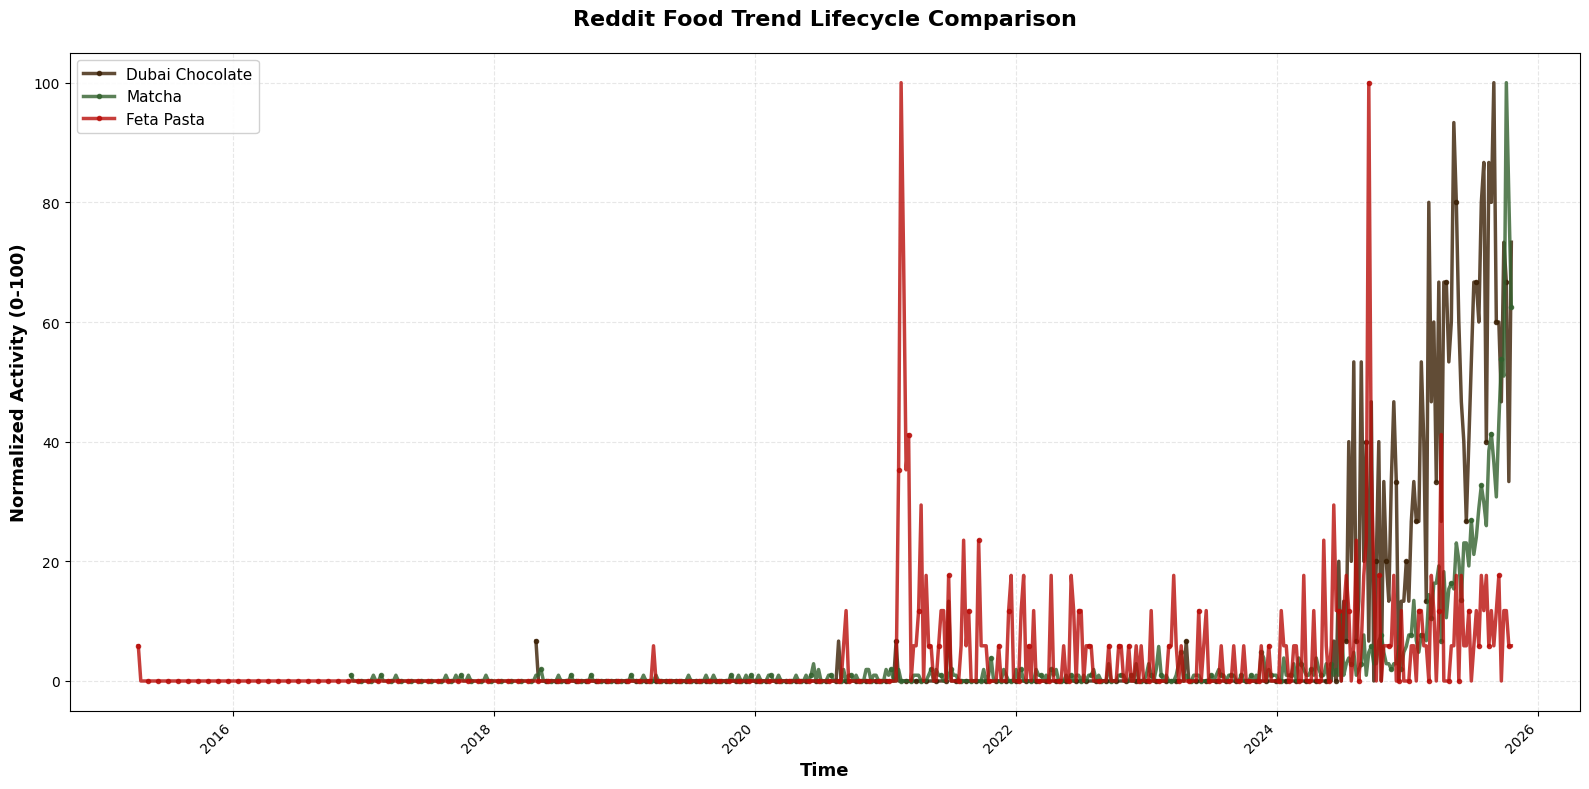

In [43]:
def plot_normalized_trends(df, trends_to_plot=None):
    """
    Shows all trends on normalized scale (0-100) to compare growth patterns
    """
    if trends_to_plot is None:
        trends_to_plot = ['dubai-chocolate', 'matcha', 'feta-pasta', 'airfryer']

    fig, ax = plt.subplots(figsize=(16, 8))

    for trend in trends_to_plot:
        trend_df = df[df['Trend_ID'] == trend].copy()

        if len(trend_df) < 10:  # Skip if too few posts
            print(f"⚠ Skipping {trend}: only {len(trend_df)} posts")
            continue

        # Weekly aggregation
        weekly_counts = (trend_df.set_index('Time_Period')
                        .resample('W')
                        .size()
                        .reset_index(name='count'))

        # Normalize to 0-100 scale
        if weekly_counts['count'].max() > 0:
            weekly_counts['normalized'] = (
                (weekly_counts['count'] - weekly_counts['count'].min()) /
                (weekly_counts['count'].max() - weekly_counts['count'].min()) * 100
            )

            ax.plot(weekly_counts['Time_Period'],
                   weekly_counts['normalized'],
                   label=trend.replace('-', ' ').title(),
                   color=CUSTOM_COLORS.get(trend, 'gray'),
                   linewidth=2.5,
                   alpha=0.8,
                   marker='o',
                   markersize=3,
                   markevery=4)

    ax.set_xlabel('Time', fontsize=13, fontweight='bold')
    ax.set_ylabel('Normalized Activity (0-100)', fontsize=13, fontweight='bold')
    ax.set_title('Reddit Food Trend Lifecycle Comparison',
                 fontsize=16, fontweight='bold', pad=20)
    ax.legend(fontsize=11, loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Run the plot
plot_normalized_trends(df)


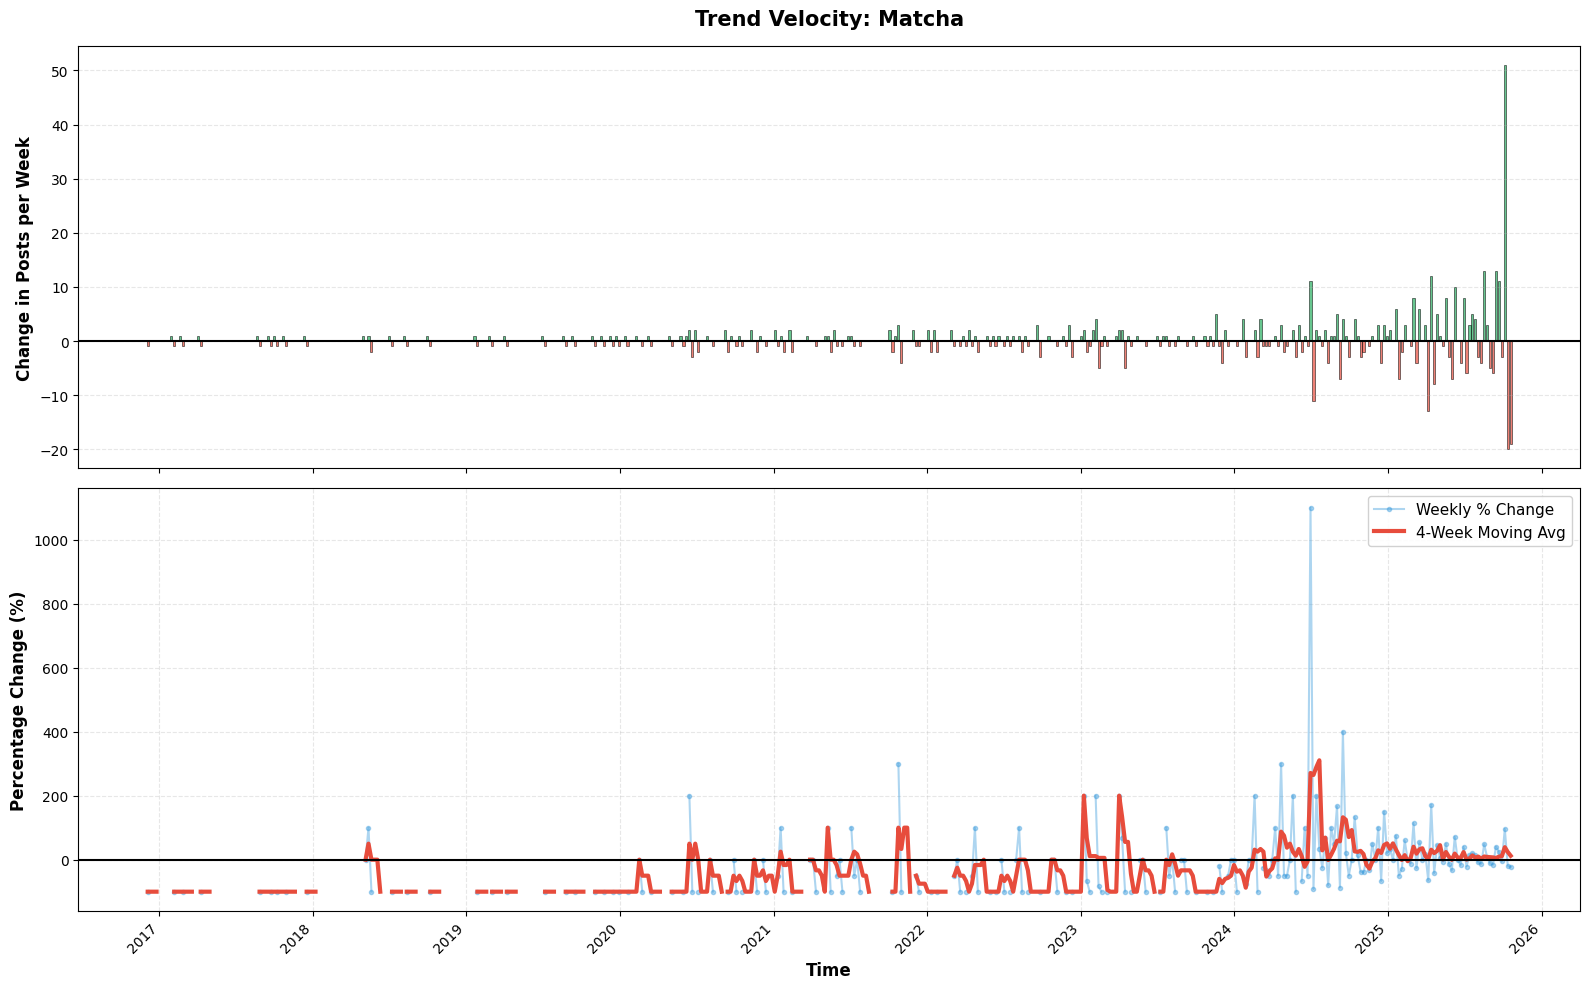

✓ Saved: matcha_velocity.png


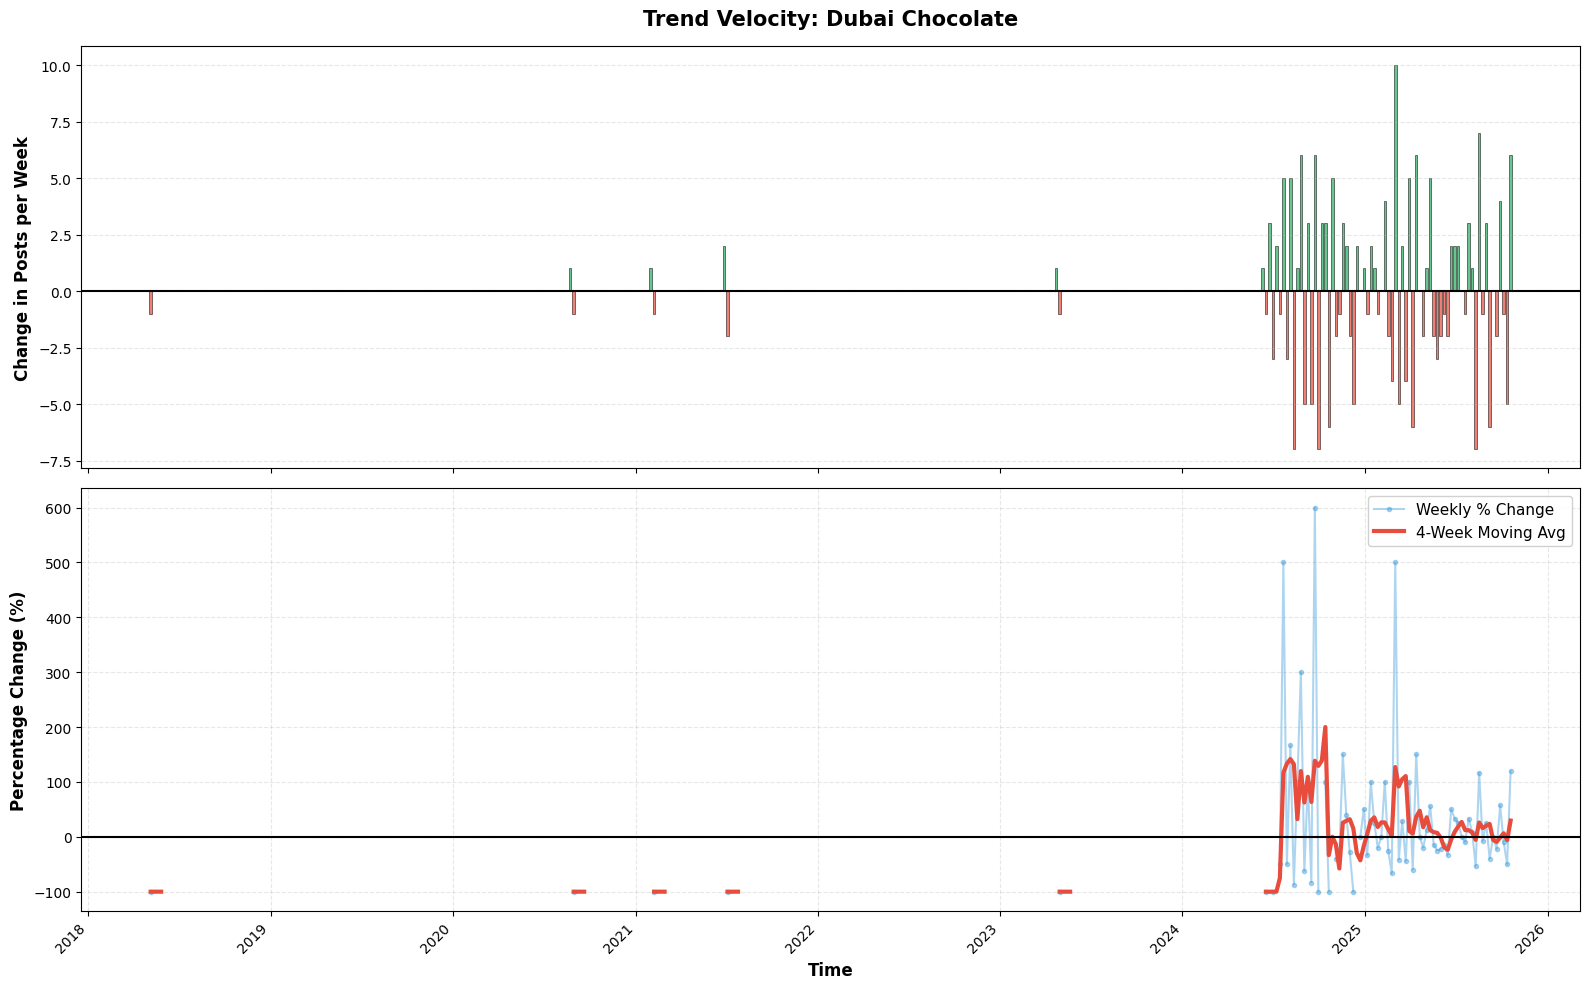

✓ Saved: dubai-chocolate_velocity.png


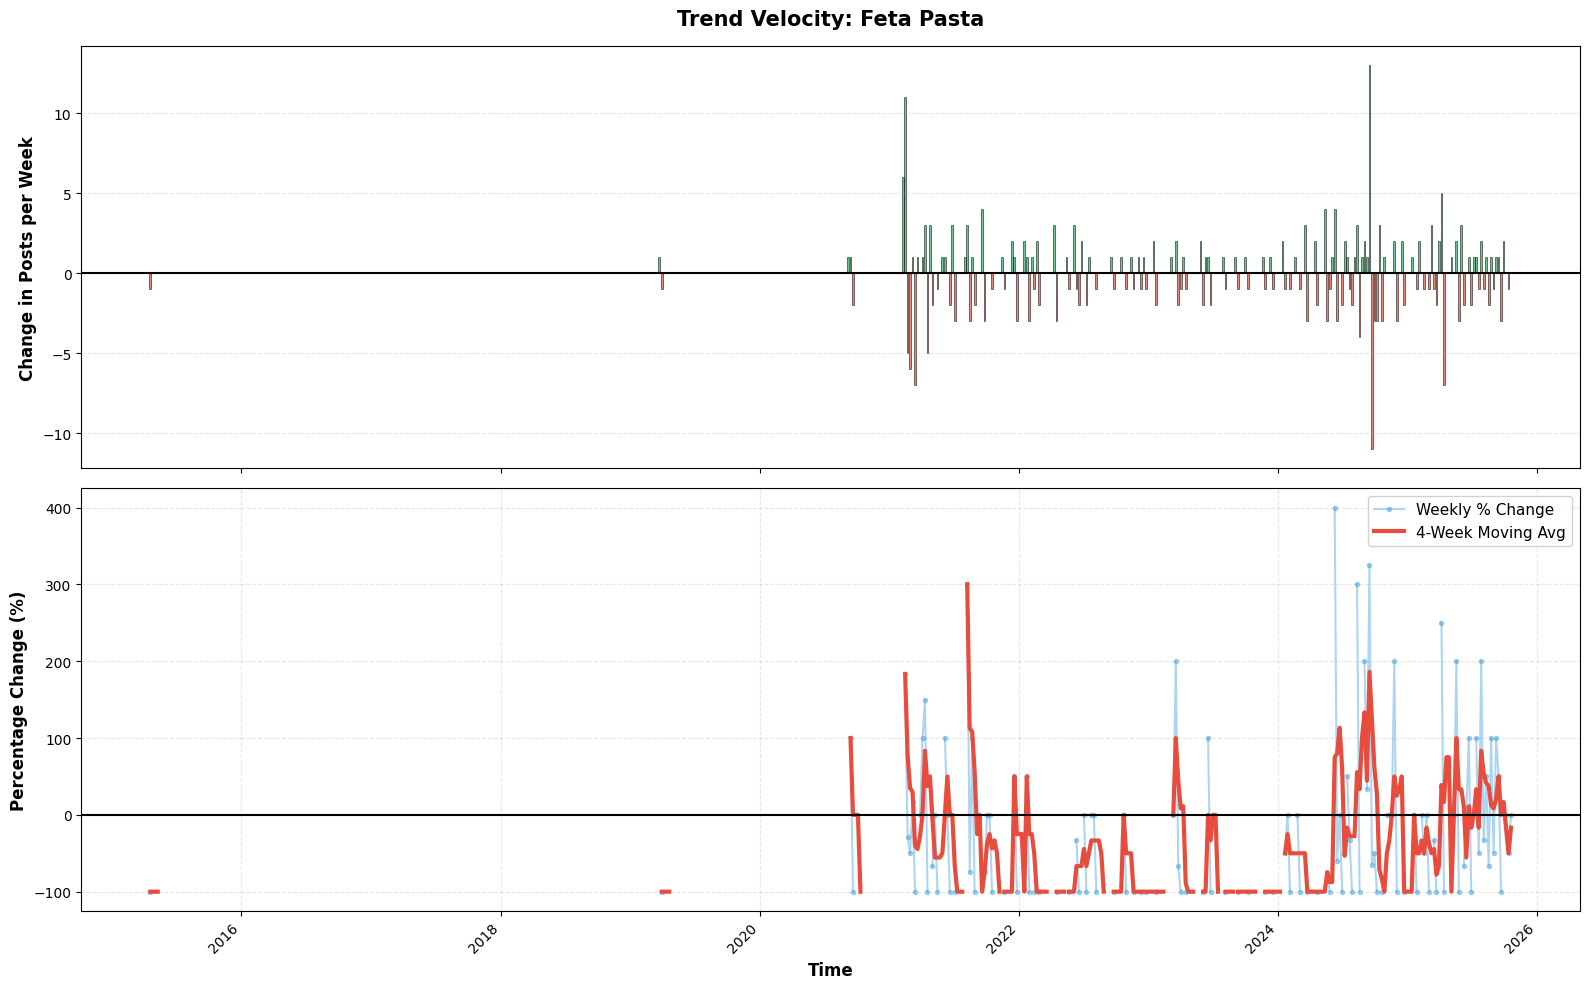

✓ Saved: feta-pasta_velocity.png


In [42]:
def plot_trend_velocity(df, trend_id='matcha'):
    """
    Shows the rate of change in posting activity
    """
    trend_df = df[df['Trend_ID'] == trend_id].copy()

    if len(trend_df) < 20:
        print(f"⚠ Not enough data for velocity analysis: only {len(trend_df)} posts")
        return

    # Weekly counts
    weekly_counts = (trend_df.set_index('Time_Period')
                    .resample('W')
                    .size()
                    .reset_index(name='count'))

    # Calculate velocity (week-over-week change)
    weekly_counts['velocity'] = weekly_counts['count'].diff()
    weekly_counts['velocity_pct'] = weekly_counts['count'].pct_change() * 100

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

    # Top: Absolute velocity
    colors = ['#27AE60' if x >= 0 else '#E74C3C' for x in weekly_counts['velocity'].fillna(0)]
    ax1.bar(weekly_counts['Time_Period'], weekly_counts['velocity'],
            color=colors, alpha=0.7, width=5, edgecolor='black', linewidth=0.5)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
    ax1.set_ylabel('Change in Posts per Week', fontsize=12, fontweight='bold')
    ax1.set_title(f'Trend Velocity: {trend_id.replace("-", " ").title()}',
                  fontsize=15, fontweight='bold', pad=15)
    ax1.grid(True, alpha=0.3, axis='y', linestyle='--')

    # Bottom: Percentage velocity with rolling average
    ax2.plot(weekly_counts['Time_Period'], weekly_counts['velocity_pct'],
            color='#3498DB', alpha=0.4, linewidth=1.5, label='Weekly % Change',
            marker='o', markersize=3)

    # Add 4-week moving average
    weekly_counts['velocity_ma'] = weekly_counts['velocity_pct'].rolling(4, min_periods=1).mean()
    ax2.plot(weekly_counts['Time_Period'], weekly_counts['velocity_ma'],
            color='#E74C3C', linewidth=3, label='4-Week Moving Avg')

    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
    ax2.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Percentage Change (%)', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=11, framealpha=0.9)
    ax2.grid(True, alpha=0.3, linestyle='--')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(f'{trend_id}_velocity.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {trend_id}_velocity.png")

# Run for trends with enough data
for trend in ['matcha', 'dubai-chocolate', 'airfryer', 'feta-pasta']:
    if len(df[df['Trend_ID'] == trend]) >= 20:
        plot_trend_velocity(df, trend)


In [44]:
!pip install nltk wordcloud textblob vaderSentiment

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter
import re

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.1 MB/s eta 0:00:00


In [45]:
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [72]:
analyzer = SentimentIntensityAnalyzer()

trends_to_analyze = ['dubai-chocolate', 'matcha', 'feta-pasta', 'airfryer']
df_trends = df[df['Trend_ID'].isin(trends_to_analyze)].copy()

print(f" Data prepared for sentiment analysis")
print(f"   Total posts: {len(df_trends)}")
print(f"   Breakdown by trend:")
for trend in trends_to_analyze:
    count = len(df_trends[df_trends['Trend_ID'] == trend])
    print(f"   • {trend}: {count} posts")

 Data prepared for sentiment analysis
   Total posts: 2179
   Breakdown by trend:
   • dubai-chocolate: 448 posts
   • matcha: 1441 posts
   • feta-pasta: 290 posts
   • airfryer: 0 posts


In [49]:
def get_vader_sentiment(text):
    """
    Get VADER sentiment scores
    Returns: compound score (-1 to 1)
    """
    if pd.isna(text) or text == '':
        return 0
    scores = analyzer.polarity_scores(str(text))
    return scores['compound']

def classify_sentiment(compound_score):
    """
    Classify sentiment into categories
    """
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

In [51]:
print(" Running VADER sentiment analysis on post titles...")
df_trends['sentiment_score'] = df_trends['title'].apply(get_vader_sentiment)
df_trends['sentiment_category'] = df_trends['sentiment_score'].apply(classify_sentiment)

print("✓ Sentiment analysis complete!")
print(f" Overall Sentiment Distribution:")
print(df_trends['sentiment_category'].value_counts())
print(f" Average Sentiment by Trend:")
for trend in trends_to_analyze:
    trend_df = df_trends[df_trends['Trend_ID'] == trend]
    avg_sentiment = trend_df['sentiment_score'].mean()
    print(f"   • {trend}: {avg_sentiment:.3f}")

 Running VADER sentiment analysis on post titles...
✓ Sentiment analysis complete!
 Overall Sentiment Distribution:
sentiment_category
Neutral     1470
Positive     488
Negative     221
Name: count, dtype: int64
 Average Sentiment by Trend:
   • dubai-chocolate: 0.016
   • matcha: 0.085
   • feta-pasta: 0.068
   • airfryer: nan


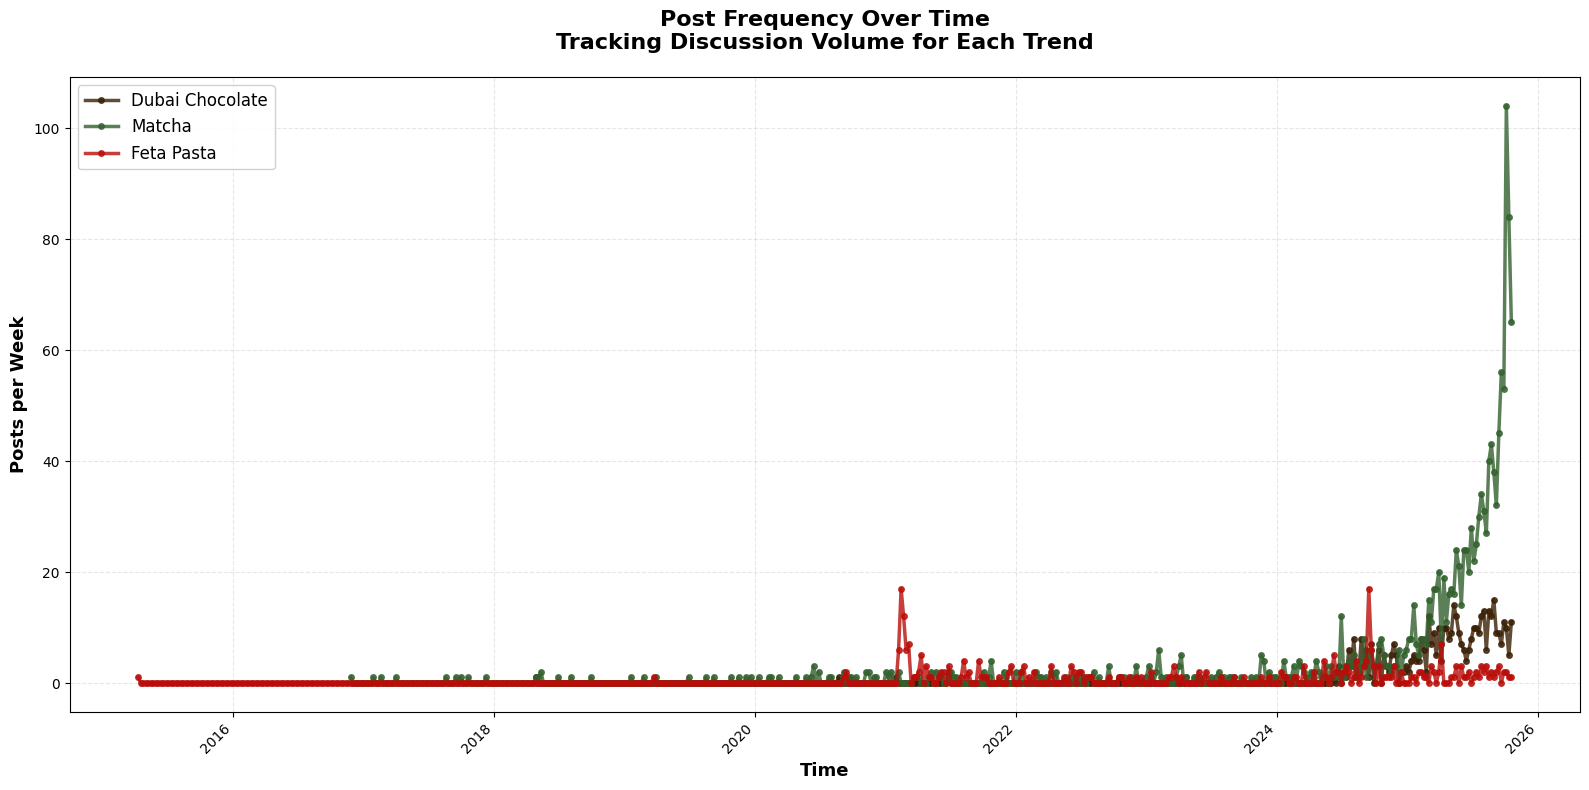

✓ Insight: Peaks show moments of viral hype or controversy


In [53]:
def plot_post_frequency_over_time(df_trends):
    """
    Track how often users discussed each trend
    """
    fig, ax = plt.subplots(figsize=(16, 8))

    for trend in trends_to_analyze:
        trend_df = df_trends[df_trends['Trend_ID'] == trend]

        if len(trend_df) < 5:
            continue

        # Weekly aggregation
        weekly_counts = (trend_df.set_index('Time_Period')
                        .resample('W')
                        .size()
                        .reset_index(name='post_count'))

        ax.plot(weekly_counts['Time_Period'],
               weekly_counts['post_count'],
               label=trend.replace('-', ' ').title(),
               color=CUSTOM_COLORS[trend],
               linewidth=2.5,
               marker='o',
               markersize=4,
               alpha=0.8)

    ax.set_xlabel('Time', fontsize=13, fontweight='bold')
    ax.set_ylabel('Posts per Week', fontsize=13, fontweight='bold')
    ax.set_title('Post Frequency Over Time\nTracking Discussion Volume for Each Trend',
                 fontsize=16, fontweight='bold', pad=20)
    ax.legend(fontsize=12, loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("✓ Insight: Peaks show moments of viral hype or controversy")

plot_post_frequency_over_time(df_trends)


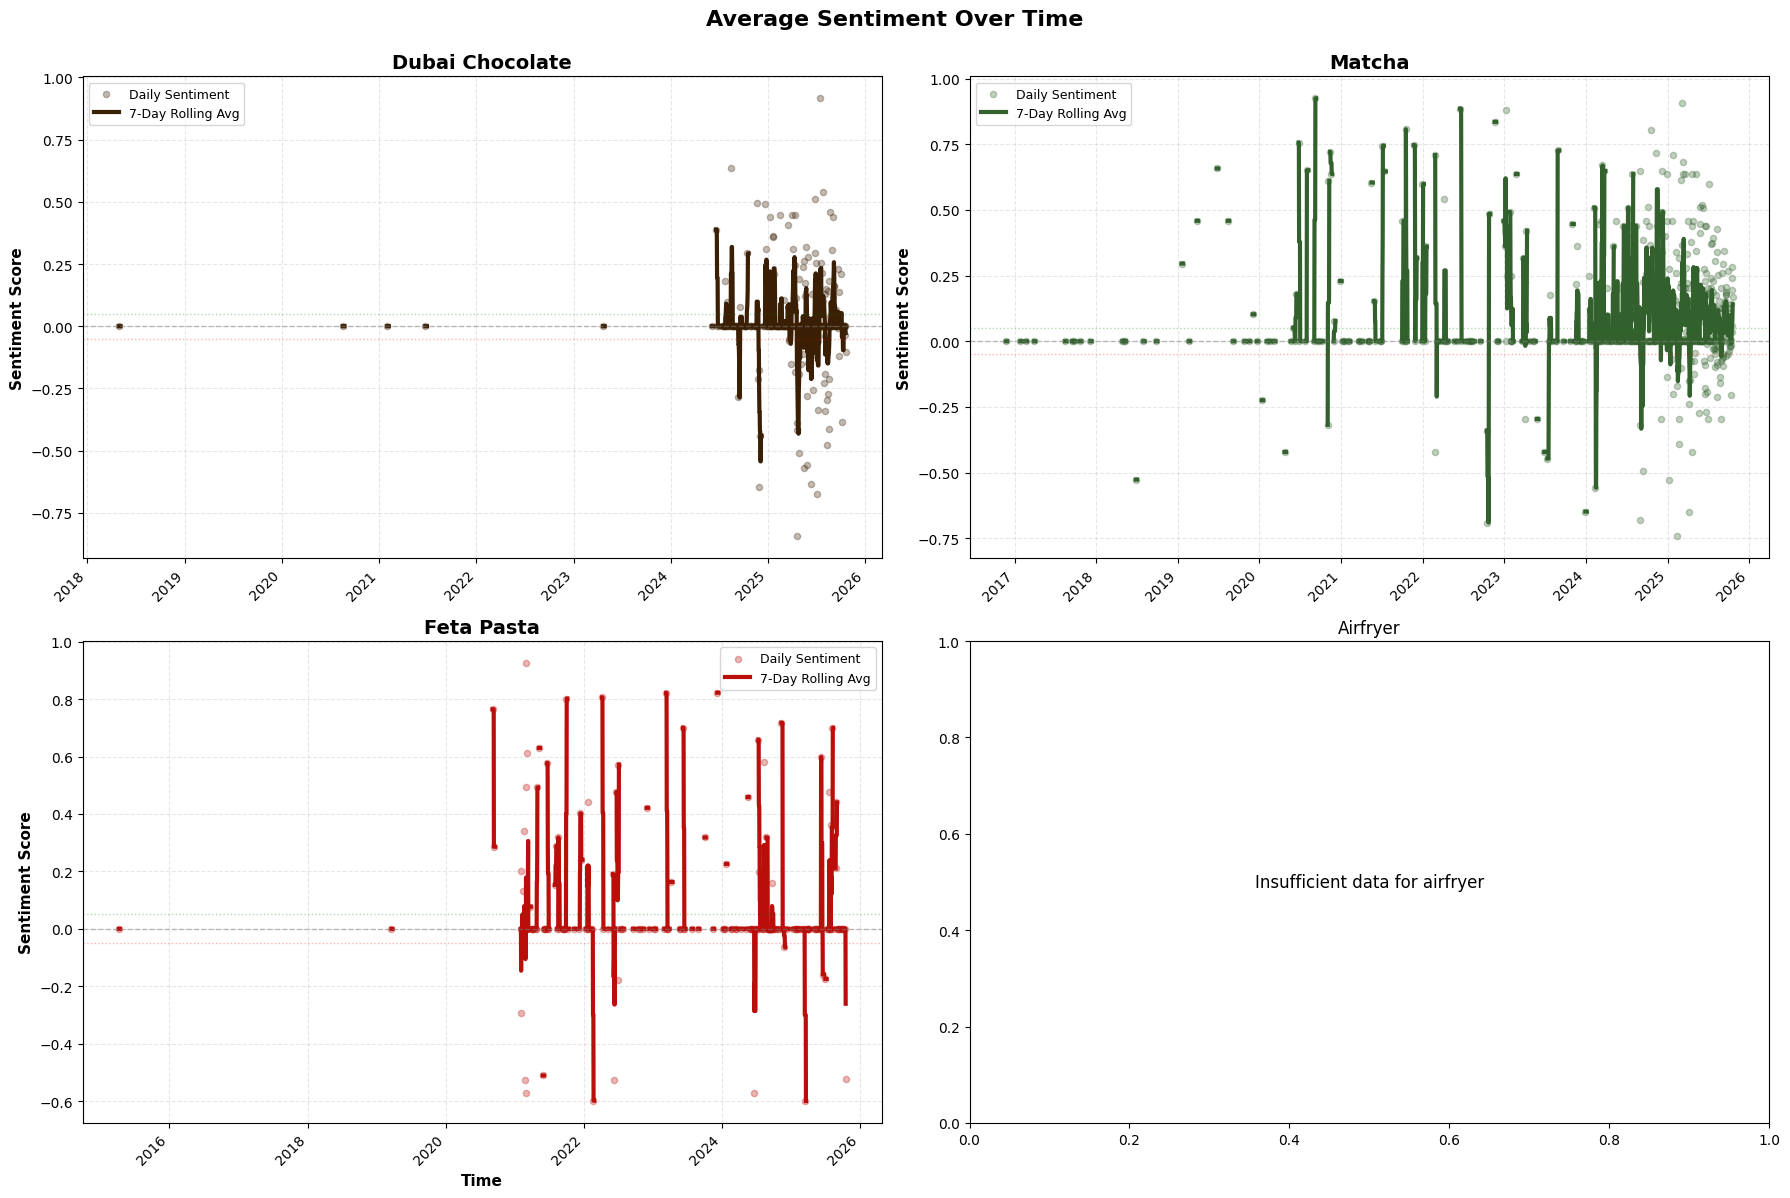

In [70]:
def plot_sentiment_over_time(df_trends):
    """
    Measure how user sentiment changes over time
    """
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()

    for idx, trend in enumerate(trends_to_analyze):
        trend_df = df_trends[df_trends['Trend_ID'] == trend].copy()

        if len(trend_df) < 10:
            axes[idx].text(0.5, 0.5, f'Insufficient data for {trend}',
                          ha='center', va='center', fontsize=12)
            axes[idx].set_title(trend.replace('-', ' ').title())
            continue

        # Daily sentiment average
        daily_sentiment = (trend_df.set_index('Time_Period')
                          .resample('D')['sentiment_score']
                          .mean()
                          .reset_index())

        # Calculate 7-day rolling average
        daily_sentiment['rolling_avg'] = daily_sentiment['sentiment_score'].rolling(
            window=7, min_periods=1
        ).mean()

        # Plot raw sentiment (light)
        axes[idx].scatter(daily_sentiment['Time_Period'],
                         daily_sentiment['sentiment_score'],
                         alpha=0.3, s=20, color=CUSTOM_COLORS[trend],
                         label='Daily Sentiment')

        # Plot rolling average (bold)
        axes[idx].plot(daily_sentiment['Time_Period'],
                      daily_sentiment['rolling_avg'],
                      color=CUSTOM_COLORS[trend],
                      linewidth=3,
                      label='7-Day Rolling Avg')

        # Add reference lines
        axes[idx].axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        axes[idx].axhline(y=0.05, color='green', linestyle=':', linewidth=1, alpha=0.3)
        axes[idx].axhline(y=-0.05, color='red', linestyle=':', linewidth=1, alpha=0.3)

        axes[idx].set_title(trend.replace('-', ' ').title(),
                           fontsize=14, fontweight='bold')
        axes[idx].set_ylabel('Sentiment Score', fontsize=11, fontweight='bold')
        axes[idx].grid(True, alpha=0.3, linestyle='--')
        axes[idx].legend(fontsize=9)

        if idx >= 2:
            axes[idx].set_xlabel('Time', fontsize=11, fontweight='bold')

        plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=45, ha='right')

    fig.suptitle('Average Sentiment Over Time',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

plot_sentiment_over_time(df_trends)



/tmp/ipython-input-946938413.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(sentiment_data,


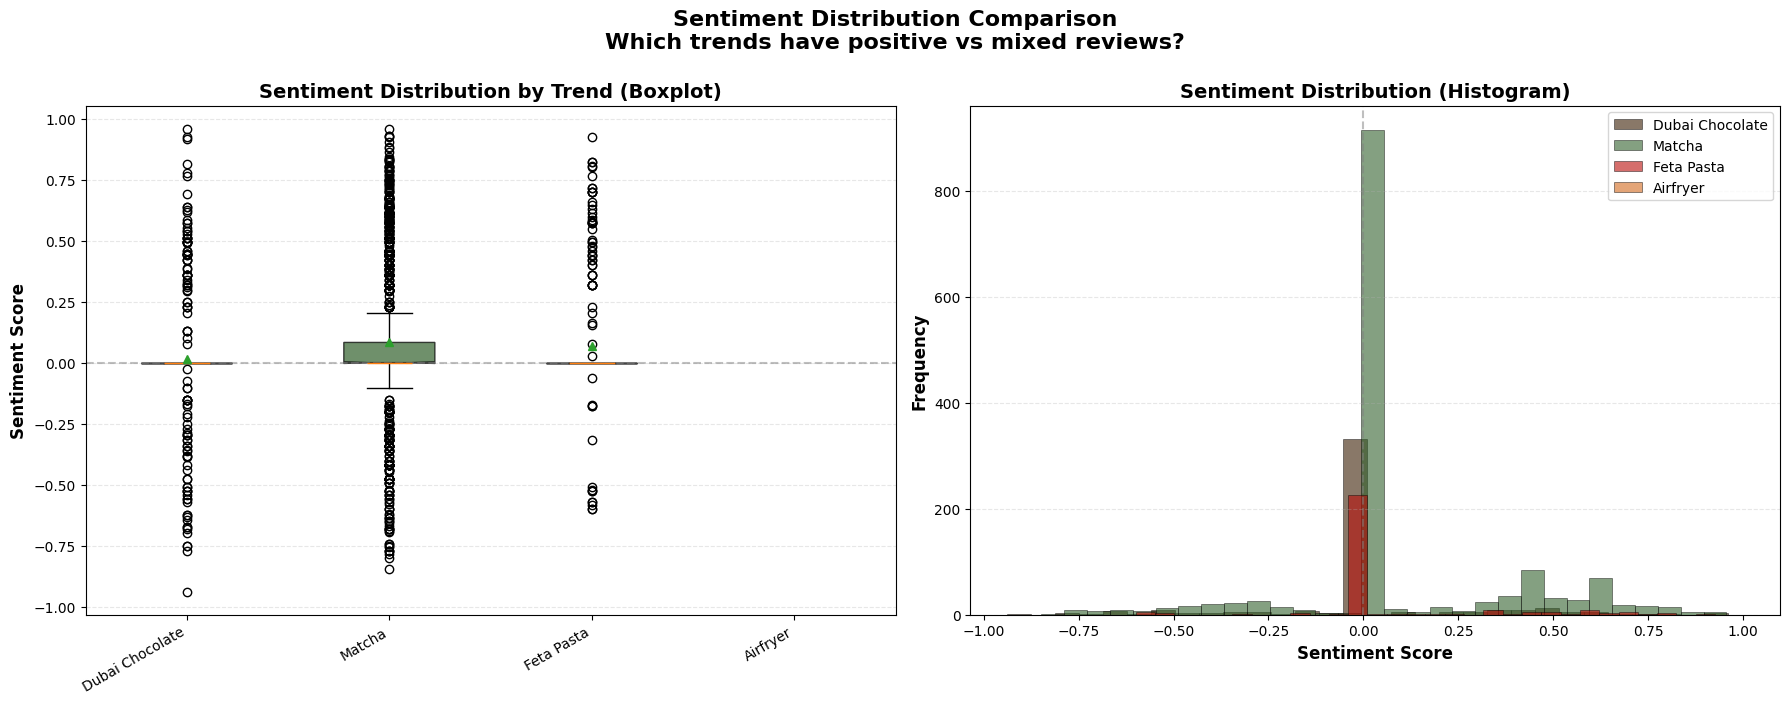

✓ Insight: Airfryer likely positive; controversial trends show wider spread


In [69]:
def plot_sentiment_distribution(df_trends):
    """
    Compare general emotional tone across trends
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # BOXPLOT
    sentiment_data = [df_trends[df_trends['Trend_ID'] == trend]['sentiment_score'].dropna()
                     for trend in trends_to_analyze]

    bp = ax1.boxplot(sentiment_data,
                     labels=[t.replace('-', ' ').title() for t in trends_to_analyze],
                     patch_artist=True,
                     notch=True,
                     showmeans=True)

    # Color the boxes
    for patch, trend in zip(bp['boxes'], trends_to_analyze):
        patch.set_facecolor(CUSTOM_COLORS[trend])
        patch.set_alpha(0.7)

    ax1.axhline(y=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
    ax1.set_ylabel('Sentiment Score', fontsize=12, fontweight='bold')
    ax1.set_title('Sentiment Distribution by Trend (Boxplot)',
                  fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y', linestyle='--')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=30, ha='right')

    # HISTOGRAM
    for trend in trends_to_analyze:
        trend_df = df_trends[df_trends['Trend_ID'] == trend]
        ax2.hist(trend_df['sentiment_score'],
                bins=30,
                alpha=0.6,
                label=trend.replace('-', ' ').title(),
                color=CUSTOM_COLORS[trend],
                edgecolor='black',
                linewidth=0.5)

    ax2.axvline(x=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
    ax2.set_xlabel('Sentiment Score', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax2.set_title('Sentiment Distribution (Histogram)',
                  fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y', linestyle='--')

    fig.suptitle('Sentiment Distribution Comparison\nWhich trends have positive vs mixed reviews?',
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

    print("✓ Insight: Airfryer likely positive; controversial trends show wider spread")

plot_sentiment_distribution(df_trends)

/tmp/ipython-input-1089239963.py:39: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


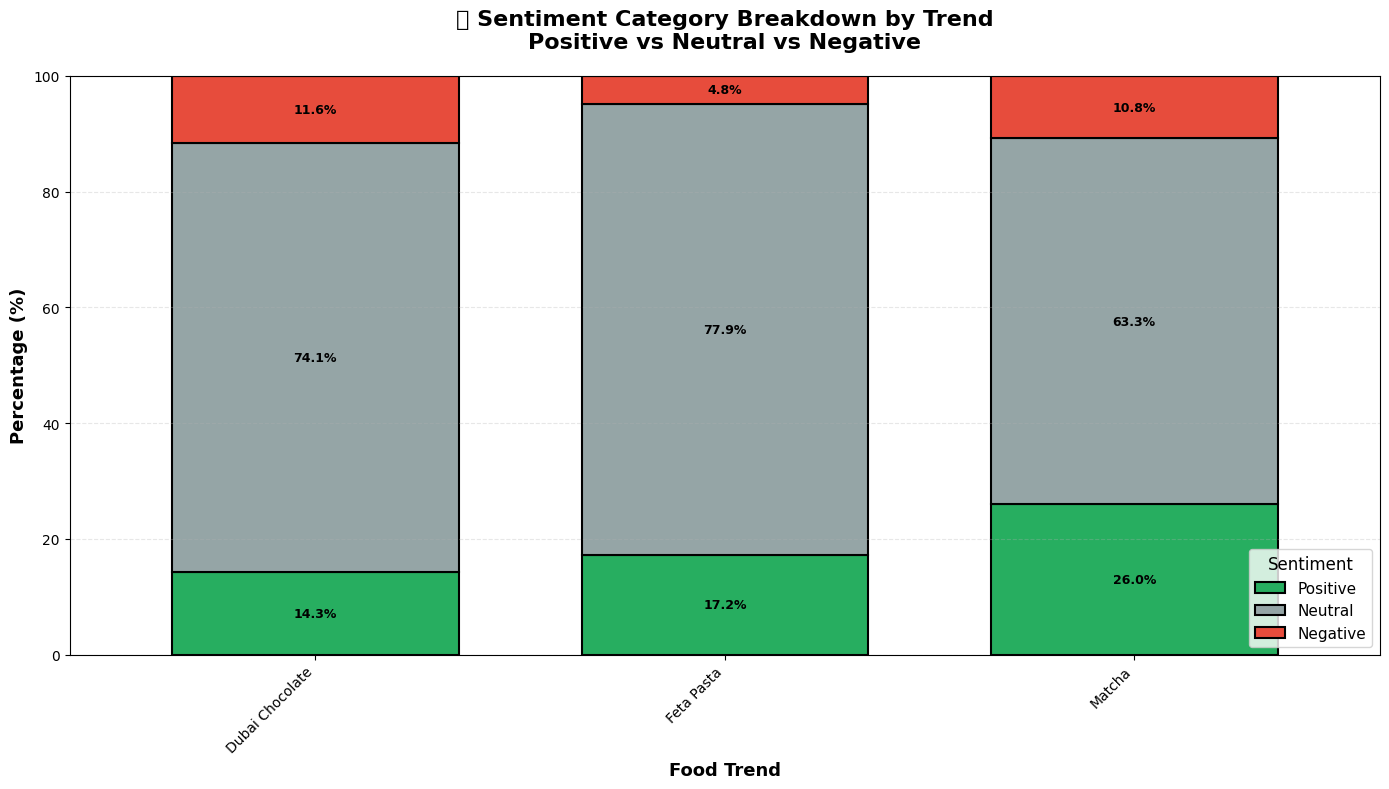

✓ Insight: Shows overall sentiment balance for each trend


In [55]:
def plot_sentiment_category_breakdown(df_trends):
    """
    Show proportion of positive/neutral/negative for each trend
    """
    fig, ax = plt.subplots(figsize=(14, 8))

    # Calculate percentages
    sentiment_breakdown = df_trends.groupby(['Trend_ID', 'sentiment_category']).size().unstack(fill_value=0)
    sentiment_pct = sentiment_breakdown.div(sentiment_breakdown.sum(axis=1), axis=0) * 100

    # Reorder for better visualization
    sentiment_pct = sentiment_pct[['Positive', 'Neutral', 'Negative']]

    # Rename index for display
    sentiment_pct.index = [t.replace('-', ' ').title() for t in sentiment_pct.index]

    # Plot stacked bar
    sentiment_pct.plot(kind='bar',
                       stacked=True,
                       ax=ax,
                       color=['#27AE60', '#95A5A6', '#E74C3C'],
                       width=0.7,
                       edgecolor='black',
                       linewidth=1.5)

    ax.set_ylabel('Percentage (%)', fontsize=13, fontweight='bold')
    ax.set_xlabel('Food Trend', fontsize=13, fontweight='bold')
    ax.set_title('📊 Sentiment Category Breakdown by Trend\nPositive vs Neutral vs Negative',
                 fontsize=16, fontweight='bold', pad=20)
    ax.legend(title='Sentiment', fontsize=11, title_fontsize=12)
    ax.set_ylim(0, 100)
    plt.xticks(rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')

    # Add percentage labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9, weight='bold')

    plt.tight_layout()
    plt.show()

    print("✓ Insight: Shows overall sentiment balance for each trend")

plot_sentiment_category_breakdown(df_trends)


/tmp/ipython-input-3212149892.py:36: UserWarning: Glyph 127960 (\N{HOUSE BUILDINGS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127960 (\N{HOUSE BUILDINGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


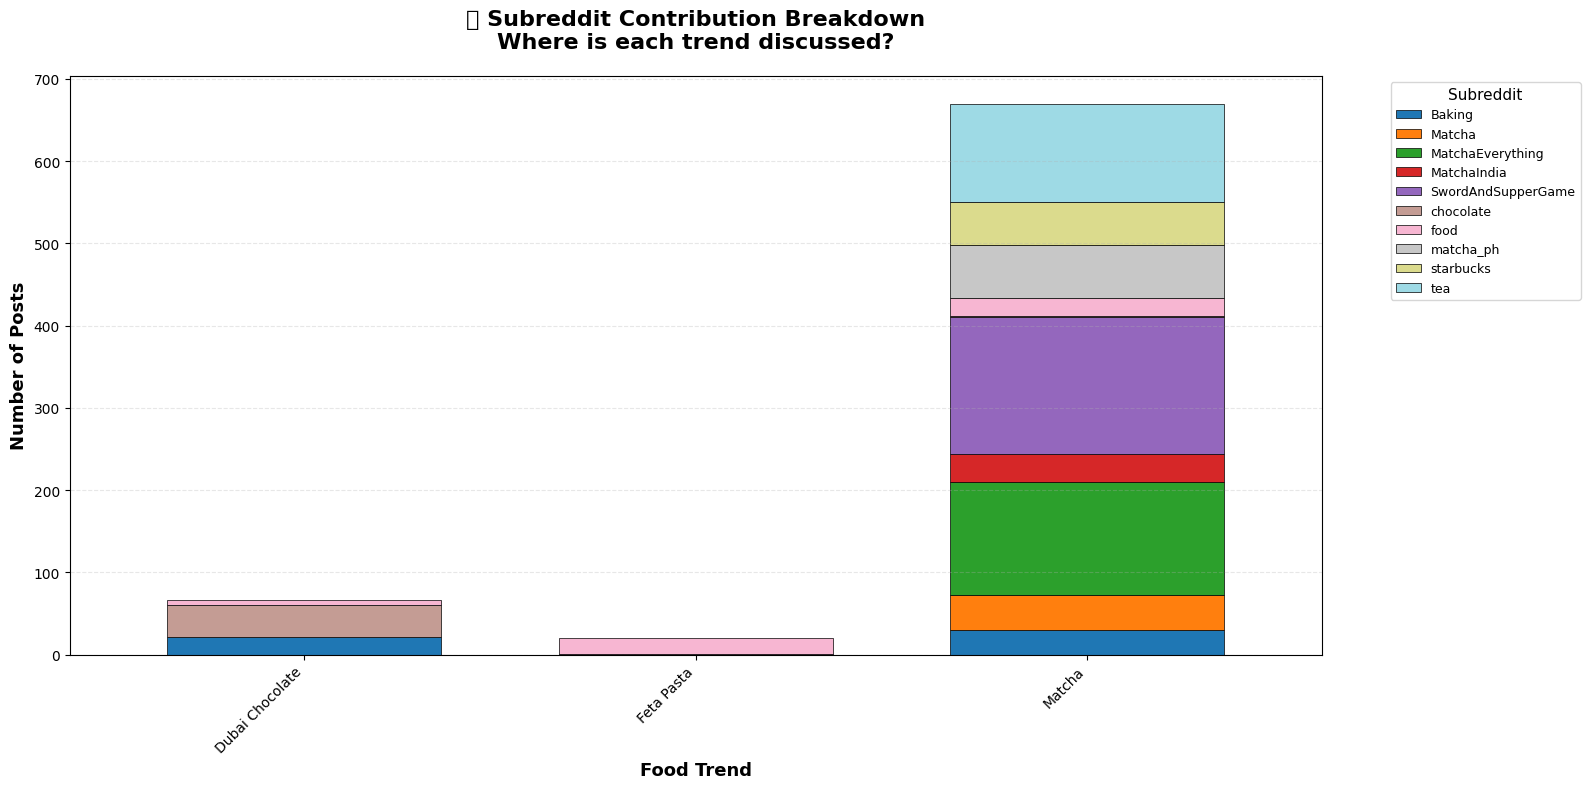

✓ Insight: Reveals where discussion lives (r/Food, r/Cooking, etc.)


In [56]:
def plot_subreddit_breakdown(df_trends):
    """
    Show which subreddits talk about each trend
    """
    fig, ax = plt.subplots(figsize=(16, 8))

    # Get top 10 subreddits overall
    top_subs = df_trends['subreddit'].value_counts().head(10).index

    # Create pivot table
    sub_breakdown = df_trends[df_trends['subreddit'].isin(top_subs)].groupby(
        ['Trend_ID', 'subreddit']
    ).size().unstack(fill_value=0)

    # Rename for display
    sub_breakdown.index = [t.replace('-', ' ').title() for t in sub_breakdown.index]

    # Plot stacked bar
    sub_breakdown.plot(kind='bar',
                       stacked=True,
                       ax=ax,
                       colormap='tab20',
                       width=0.7,
                       edgecolor='black',
                       linewidth=0.5)

    ax.set_ylabel('Number of Posts', fontsize=13, fontweight='bold')
    ax.set_xlabel('Food Trend', fontsize=13, fontweight='bold')
    ax.set_title('🏘️ Subreddit Contribution Breakdown\nWhere is each trend discussed?',
                 fontsize=16, fontweight='bold', pad=20)
    ax.legend(title='Subreddit', fontsize=9, title_fontsize=11,
             bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')

    plt.tight_layout()
    plt.show()

    print("✓ Insight: Reveals where discussion lives (r/Food, r/Cooking, etc.)")

plot_subreddit_breakdown(df_trends)

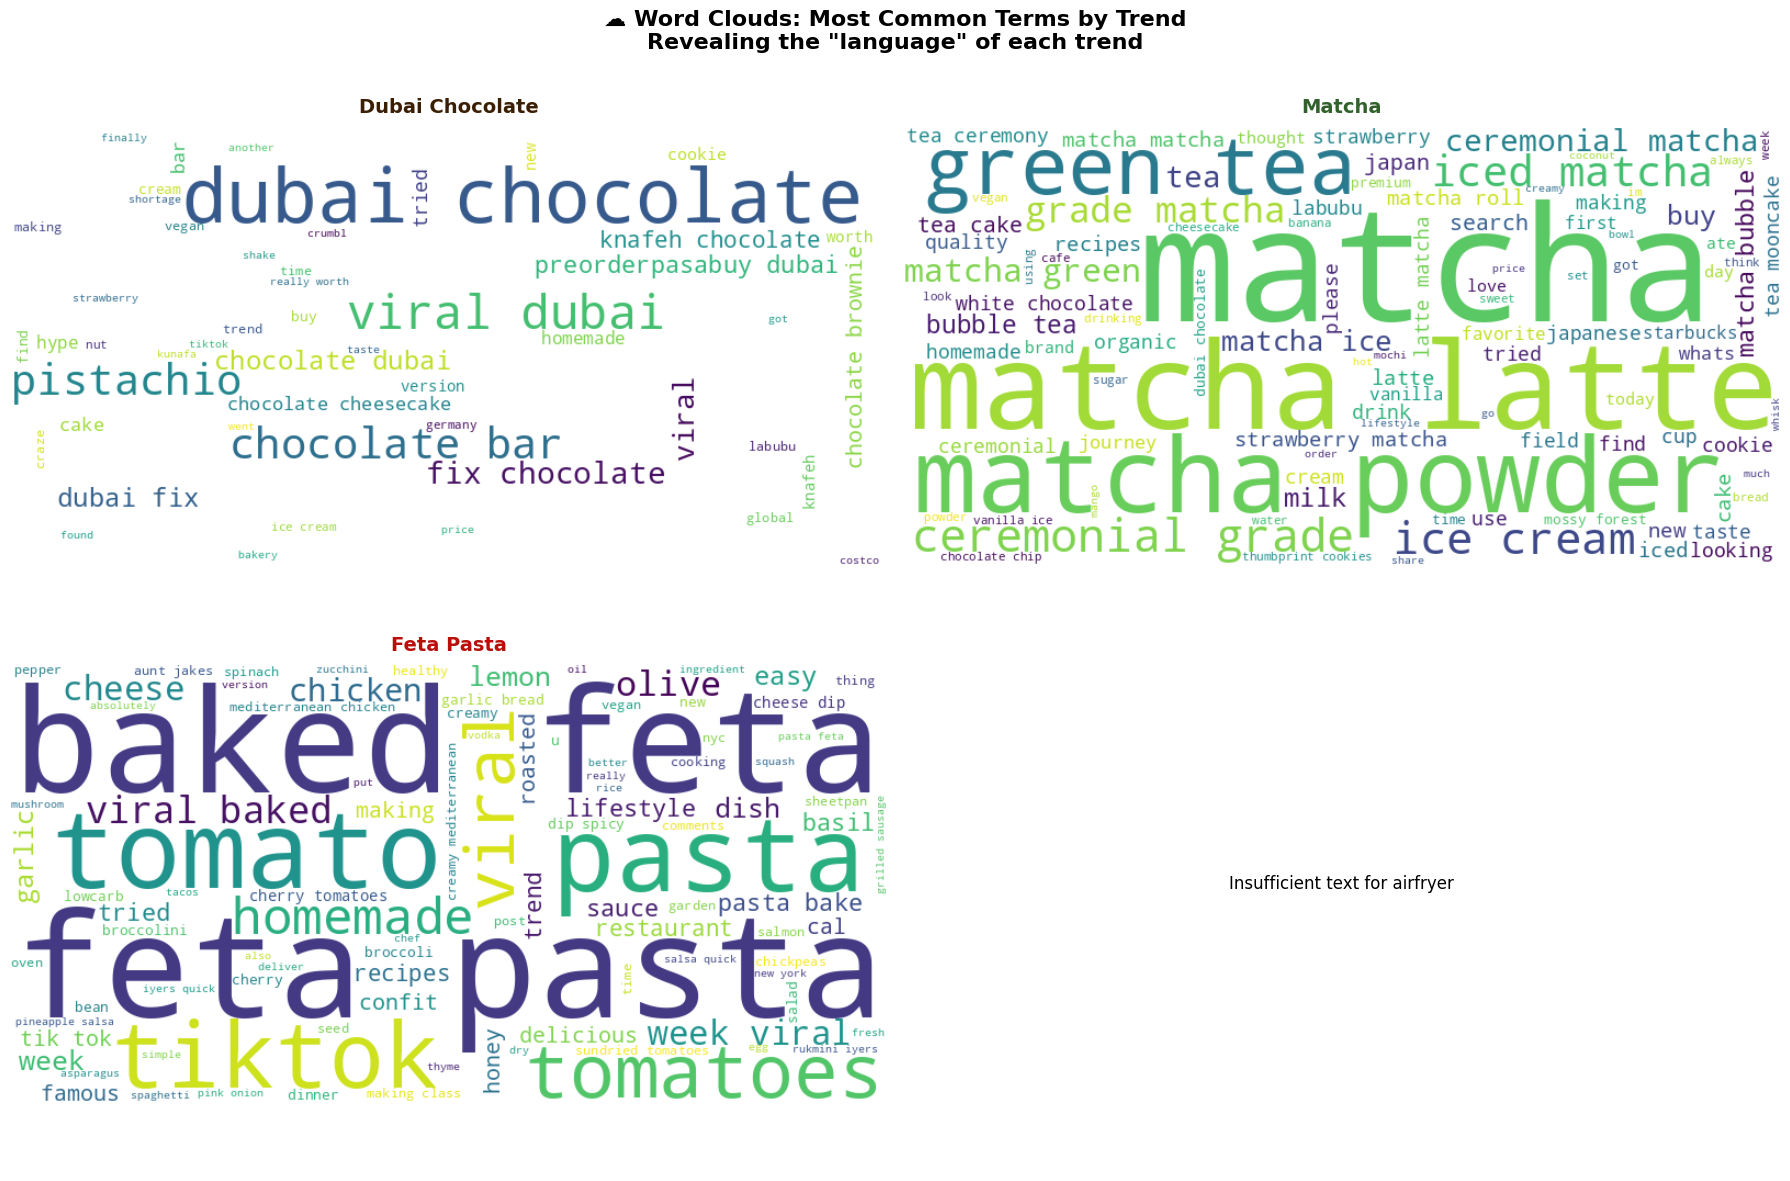

✓ Insight: Shows emotional tone and functional talk patterns


In [57]:
def plot_word_clouds(df_trends):
    """
    Show most frequent terms in posts for each trend
    """
    # Prepare stopwords
    stop_words = set(stopwords.words('english'))
    # Add custom food-related stopwords
    custom_stops = {'recipe', 'food', 'make', 'made', 'anyone', 'like', 'get',
                   'want', 'try', 'help', 'know', 'one', 'good', 'best'}
    stop_words.update(custom_stops)

    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()

    for idx, trend in enumerate(trends_to_analyze):
        trend_df = df_trends[df_trends['Trend_ID'] == trend]

        # Combine all titles
        text = ' '.join(trend_df['title'].astype(str).tolist())

        # Clean text
        text = re.sub(r'http\S+', '', text)  # Remove URLs
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only letters
        text = text.lower()

        if len(text) < 50:
            axes[idx].text(0.5, 0.5, f'Insufficient text for {trend}',
                          ha='center', va='center', fontsize=12)
            axes[idx].axis('off')
            continue

        # Generate word cloud
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            stopwords=stop_words,
            colormap='viridis',
            max_words=100,
            relative_scaling=0.5,
            min_font_size=10
        ).generate(text)

        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].axis('off')
        axes[idx].set_title(trend.replace('-', ' ').title(),
                           fontsize=14, fontweight='bold', pad=10,
                           color=CUSTOM_COLORS[trend])

    fig.suptitle('☁️ Word Clouds: Most Common Terms by Trend\nRevealing the "language" of each trend',
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

    print("✓ Insight: Shows emotional tone and functional talk patterns")

plot_word_clouds(df_trends)

/tmp/ipython-input-3321759549.py:53: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


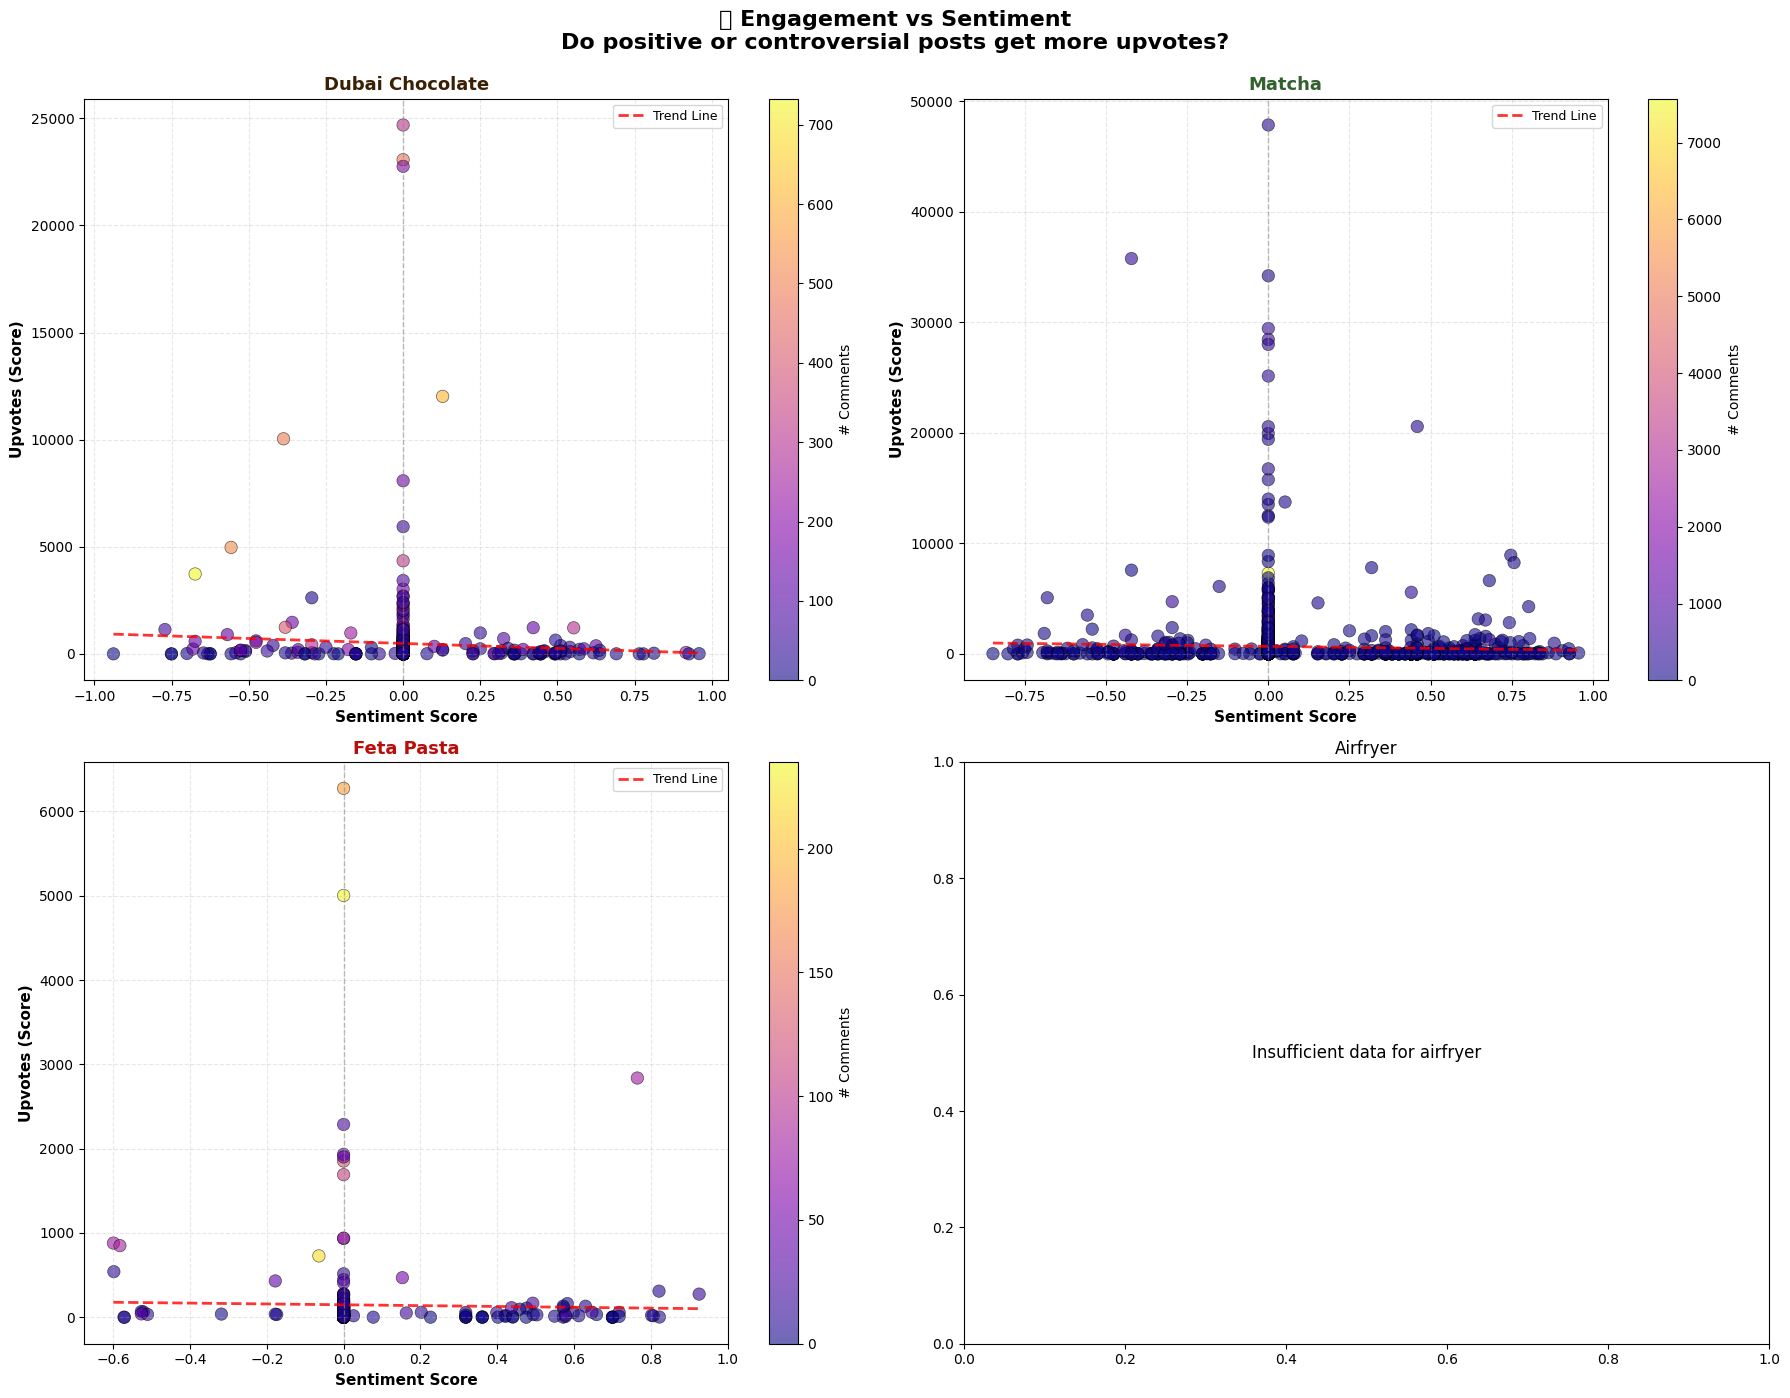

✓ Insight: Controversial/humorous content often drives higher engagement


In [58]:
def plot_engagement_vs_sentiment(df_trends):
    """
    Explore whether positive or negative posts get more engagement
    """
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.flatten()

    for idx, trend in enumerate(trends_to_analyze):
        trend_df = df_trends[df_trends['Trend_ID'] == trend].copy()

        if len(trend_df) < 10:
            axes[idx].text(0.5, 0.5, f'Insufficient data for {trend}',
                          ha='center', va='center', fontsize=12)
            axes[idx].set_title(trend.replace('-', ' ').title())
            continue

        # Create scatter plot
        scatter = axes[idx].scatter(
            trend_df['sentiment_score'],
            trend_df['score'],
            c=trend_df['num_comments'],
            cmap='plasma',
            s=80,
            alpha=0.6,
            edgecolors='black',
            linewidth=0.5
        )

        # Add trendline
        z = np.polyfit(trend_df['sentiment_score'], trend_df['score'], 1)
        p = np.poly1d(z)
        axes[idx].plot(trend_df['sentiment_score'].sort_values(),
                      p(trend_df['sentiment_score'].sort_values()),
                      "r--", linewidth=2, alpha=0.8, label='Trend Line')

        # Reference lines
        axes[idx].axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

        axes[idx].set_xlabel('Sentiment Score', fontsize=11, fontweight='bold')
        axes[idx].set_ylabel('Upvotes (Score)', fontsize=11, fontweight='bold')
        axes[idx].set_title(trend.replace('-', ' ').title(),
                           fontsize=13, fontweight='bold',
                           color=CUSTOM_COLORS[trend])
        axes[idx].grid(True, alpha=0.3, linestyle='--')
        axes[idx].legend(fontsize=9)

        # Add colorbar
        cbar = plt.colorbar(scatter, ax=axes[idx])
        cbar.set_label('# Comments', fontsize=10)

    fig.suptitle('💬 Engagement vs Sentiment\nDo positive or controversial posts get more upvotes?',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

    print("✓ Insight: Controversial/humorous content often drives higher engagement")

plot_engagement_vs_sentiment(df_trends)


/tmp/ipython-input-551771698.py:57: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


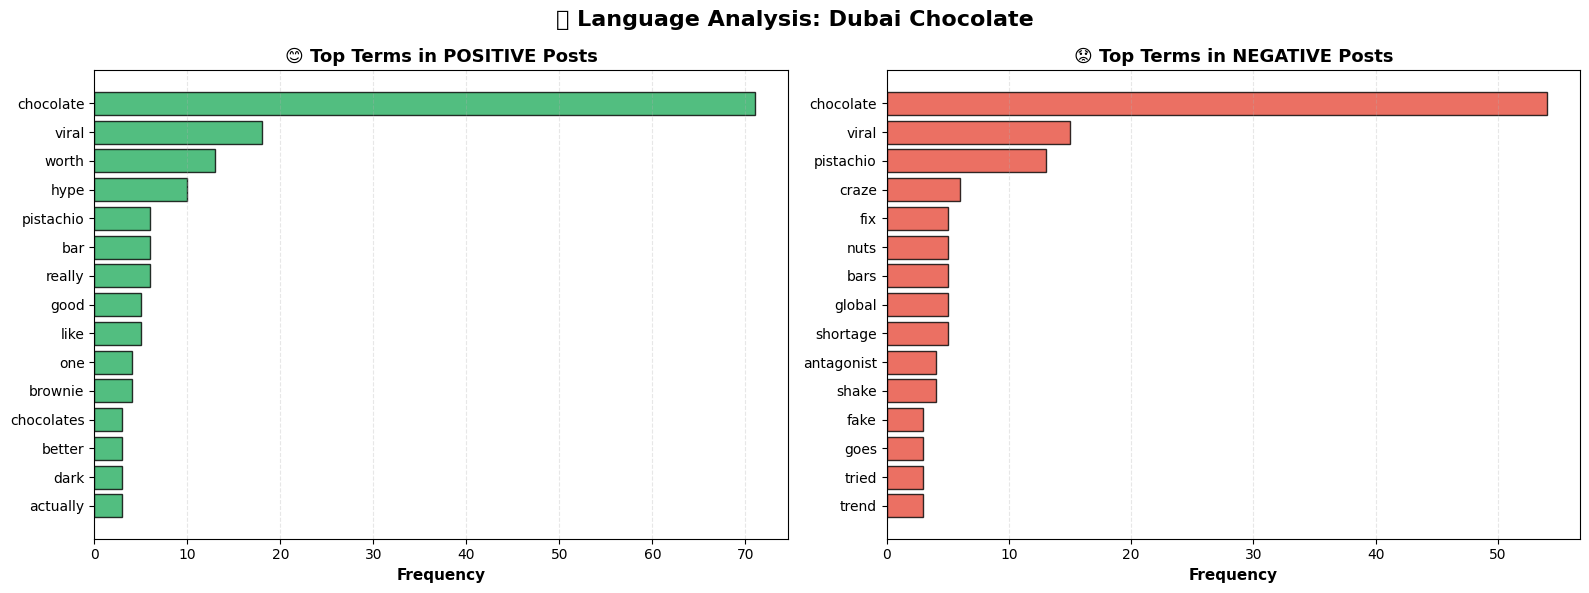

✓ Insight: Shows what language defines positive vs negative posts


/tmp/ipython-input-551771698.py:57: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


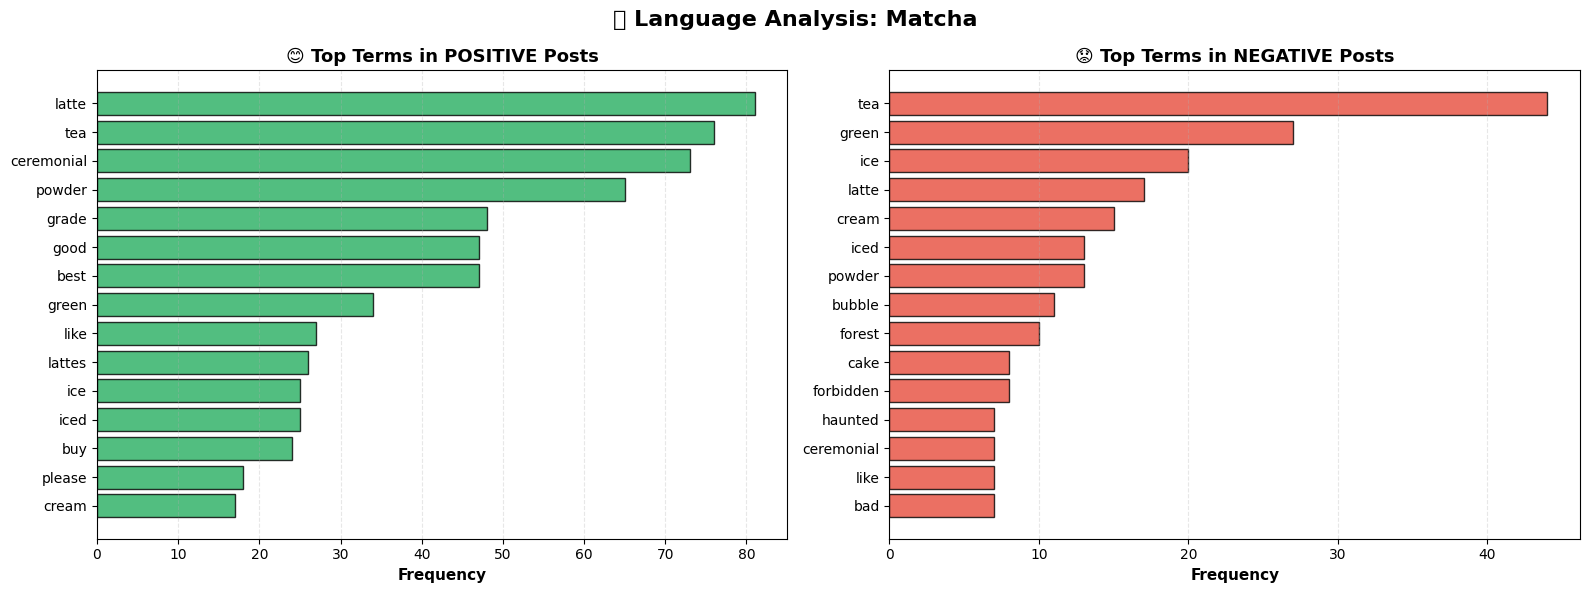

✓ Insight: Shows what language defines positive vs negative posts


/tmp/ipython-input-551771698.py:57: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


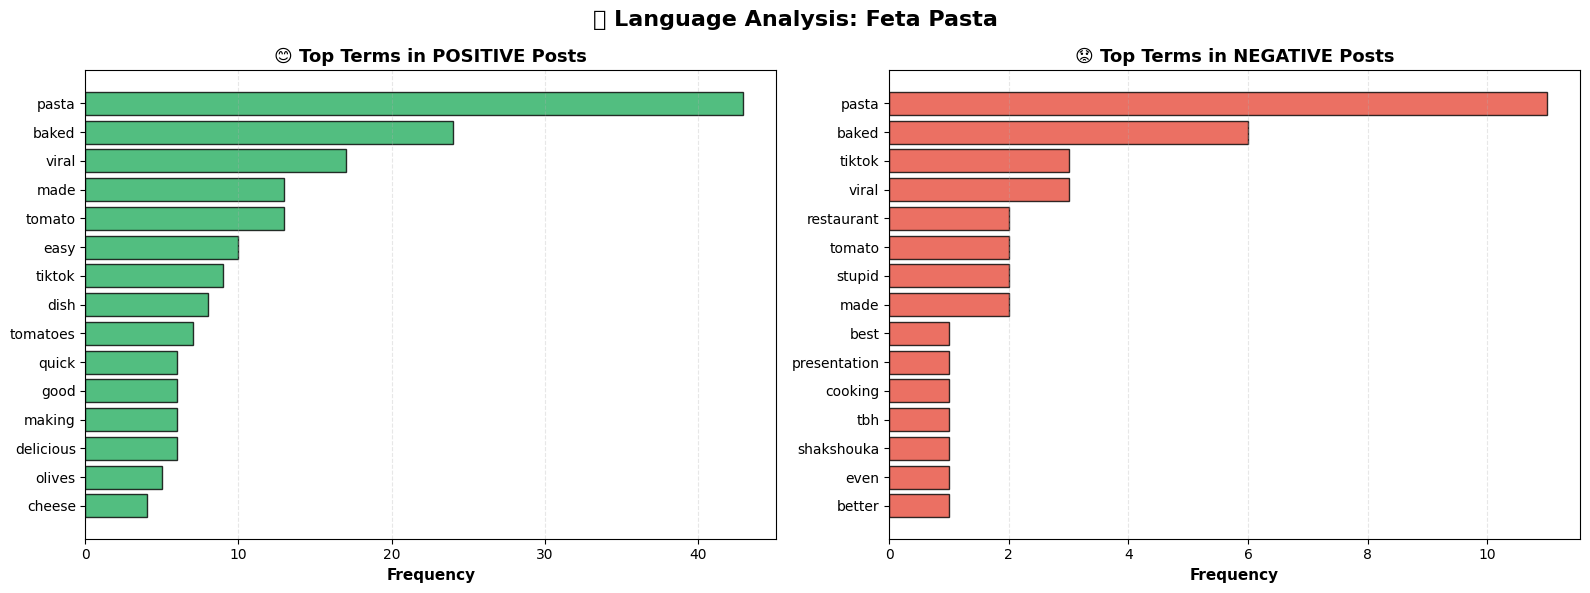

✓ Insight: Shows what language defines positive vs negative posts
⚠️ Not enough data for airfryer


In [59]:
def plot_top_terms_by_sentiment(df_trends, trend_id='matcha'):
    """
    Show what words appear in positive vs negative posts
    """
    trend_df = df_trends[df_trends['Trend_ID'] == trend_id].copy()

    if len(trend_df) < 20:
        print(f"⚠️ Not enough data for {trend_id}")
        return

    # Prepare stopwords
    stop_words = set(stopwords.words('english'))
    custom_stops = {'recipe', 'food', trend_id.replace('-', ' ').split()[0]}
    stop_words.update(custom_stops)

    # Split by sentiment
    positive_posts = trend_df[trend_df['sentiment_category'] == 'Positive']['title']
    negative_posts = trend_df[trend_df['sentiment_category'] == 'Negative']['title']

    def get_top_words(texts, n=15):
        all_words = []
        for text in texts:
            words = re.findall(r'\b[a-z]{3,}\b', str(text).lower())
            all_words.extend([w for w in words if w not in stop_words])
        return Counter(all_words).most_common(n)

    pos_words = get_top_words(positive_posts)
    neg_words = get_top_words(negative_posts)

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Positive words
    if pos_words:
        words, counts = zip(*pos_words)
        ax1.barh(range(len(words)), counts, color='#27AE60', alpha=0.8, edgecolor='black')
        ax1.set_yticks(range(len(words)))
        ax1.set_yticklabels(words)
        ax1.invert_yaxis()
        ax1.set_xlabel('Frequency', fontsize=11, fontweight='bold')
        ax1.set_title('😊 Top Terms in POSITIVE Posts', fontsize=13, fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='x', linestyle='--')

    # Negative words
    if neg_words:
        words, counts = zip(*neg_words)
        ax2.barh(range(len(words)), counts, color='#E74C3C', alpha=0.8, edgecolor='black')
        ax2.set_yticks(range(len(words)))
        ax2.set_yticklabels(words)
        ax2.invert_yaxis()
        ax2.set_xlabel('Frequency', fontsize=11, fontweight='bold')
        ax2.set_title('😟 Top Terms in NEGATIVE Posts', fontsize=13, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='x', linestyle='--')

    fig.suptitle(f'📝 Language Analysis: {trend_id.replace("-", " ").title()}',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"✓ Insight: Shows what language defines positive vs negative posts")

# Run for each trend
for trend in trends_to_analyze:
    plot_top_terms_by_sentiment(df_trends, trend)

In [62]:
print("\n" + "="*80)
print("📊 SENTIMENT ANALYSIS SUMMARY")
print("="*80)

for trend in trends_to_analyze:
    trend_df = df_trends[df_trends['Trend_ID'] == trend]

    print(f"\n🔹 {trend.replace('-', ' ').title()}")
    print(f"   Total Posts: {len(trend_df)}")
    print(f"   Avg Sentiment: {trend_df['sentiment_score'].mean():.3f}")
    print(f"   Sentiment Distribution:")
    print(f"      • Positive: {(trend_df['sentiment_category'] == 'Positive').sum()} ({(trend_df['sentiment_category'] == 'Positive').sum()/len(trend_df)*100:.1f}%)")
    print(f"      • Neutral:  {(trend_df['sentiment_category'] == 'Neutral').sum()} ({(trend_df['sentiment_category'] == 'Neutral').sum()/len(trend_df)*100:.1f}%)")
    print(f"      • Negative: {(trend_df['sentiment_category'] == 'Negative').sum()} ({(trend_df['sentiment_category'] == 'Negative').sum()/len(trend_df)*100:.1f}%)")

    # Engagement by sentiment
    for sentiment in ['Positive', 'Neutral', 'Negative']:
        sentiment_df = trend_df[trend_df['sentiment_category'] == sentiment]
        if len(sentiment_df) > 0:
            avg_score = sentiment_df['score'].mean()
            avg_comments = sentiment_df['num_comments'].mean()
            print(f"   {sentiment} Posts → Avg Score: {avg_score:.1f}, Avg Comments: {avg_comments:.1f}")



📊 SENTIMENT ANALYSIS SUMMARY

🔹 Dubai Chocolate
   Total Posts: 448
   Avg Sentiment: 0.016
   Sentiment Distribution:
      • Positive: 64 (14.3%)
      • Neutral:  332 (74.1%)
      • Negative: 52 (11.6%)
   Positive Posts → Avg Score: 344.8, Avg Comments: 54.8
   Neutral Posts → Avg Score: 484.7, Avg Comments: 40.6
   Negative Posts → Avg Score: 615.1, Avg Comments: 90.9

🔹 Matcha
   Total Posts: 1441
   Avg Sentiment: 0.085
   Sentiment Distribution:
      • Positive: 374 (26.0%)
      • Neutral:  912 (63.3%)
      • Negative: 155 (10.8%)
   Positive Posts → Avg Score: 411.0, Avg Comments: 28.5
   Neutral Posts → Avg Score: 748.1, Avg Comments: 51.1
   Negative Posts → Avg Score: 631.2, Avg Comments: 51.6

🔹 Feta Pasta
   Total Posts: 290
   Avg Sentiment: 0.068
   Sentiment Distribution:
      • Positive: 50 (17.2%)
      • Neutral:  226 (77.9%)
      • Negative: 14 (4.8%)
   Positive Posts → Avg Score: 112.3, Avg Comments: 8.0
   Neutral Posts → Avg Score: 144.5, Avg Comments: 1

/tmp/ipython-input-617146377.py:12: RuntimeWarning: invalid value encountered in scalar divide
  print(f"      • Positive: {(trend_df['sentiment_category'] == 'Positive').sum()} ({(trend_df['sentiment_category'] == 'Positive').sum()/len(trend_df)*100:.1f}%)")
/tmp/ipython-input-617146377.py:13: RuntimeWarning: invalid value encountered in scalar divide
  print(f"      • Neutral:  {(trend_df['sentiment_category'] == 'Neutral').sum()} ({(trend_df['sentiment_category'] == 'Neutral').sum()/len(trend_df)*100:.1f}%)")
/tmp/ipython-input-617146377.py:14: RuntimeWarning: invalid value encountered in scalar divide
  print(f"      • Negative: {(trend_df['sentiment_category'] == 'Negative').sum()} ({(trend_df['sentiment_category'] == 'Negative').sum()/len(trend_df)*100:.1f}%)")
